In [ ]:
import random
import numpy as np
import math
from scipy.special import erfinv
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import time
from scipy.special import lambertw

# Zadanie 2

W zadaniu drugim zaprezentujemy kilka przydatnych metod, pozwalających na generowanie rozkładu normalnego $N(\mu, \sigma)$ o dowolnych parametrach średniej $\mu$ i odchylenia standardowego $\sigma$. 

Kody, które nie zostały zaprezentowane na zajęciach zostaną poprzedzone krótkim wprowadzeniem, zawierającym opis algorytmu. Każda zaimplementowana metoda zostanie przetestowana na próbce o danej wielkości $n$. Otrzymany wynik zwizualizujemy za pomocą unormowanego histogramu, z naniesioną gęstością rozważanego rozkładu. Następnie dokonamy porównania dystrybuanty empirycznej z teoretyczną. Te dwie procedury pozwolą nam dość dokładnie stwierdzić, czy otrzymany wynik jest zgodny z naszymi oczekiwaniami - czy faktycznie otrzymaliśmy szukany rozkład.  

W dalszej części dokonamy porównania efektywności każdej metody, licząc czasy wykonania programów dla różnych długości próbek. Otrzymane czasy naniesiemy na wspólny wykres, dzięki czemu otrzymamy odpowiedź na ulubione pytanie informatyka - który algorytm jest najszybszy?

Ostatnia część zadania pozwoli jednozacznie stwierdzić, czy zaimplementowane metody poprawnie generują rozkład normalny. W tym celu użyjemy testu Kołmogorowa-Smirnowa. Otrzymane wyniki omówimy i ocenimy użyteczność poznanych algorytmów.

## Różne metody generowania rozkładu normalnego

### Metoda odwrotnej dystrybuanty

Metoda odwrotnej dystrybuanty jest prawdopodobnie najpopularniejszą metodą generowania jakiegokolwiek rozkładu. Swoją popularność zawdzięcza przede wszystkim niezwykłej prostocie, bowiem jej implementację niemal zawsze możemy zmieścić w jednej linijce! Jedynym wyzwaniem, które musimy pokonać podczas tego procesu jest wyprowadzenie wzoru na odwrotną dystrybuantę. Oczywiście prostota tej metody jest osiągana kosztem jej dokładności, lecz przy nieskomplikowanych zastosowaniach może okazać się wystarczająca.

Teraz wyprowadzimy wzór na dystrybunatę odwrotną rozkładu normalnego. W pierwszej kolejności możemy stwierdzić, że dystrybunata $F(x)$ przyjmuje wartości jedynie w zbiorze $[0,1]$, a zatem zawsze jej wartość możemy interpretować jako pojedynczą realizację rozkładu jednostajnego $U$ na odcinku $(0,1)$. Zapiszmy tę zależność

$$ F(x) = U$$

Następnie stwierdzimy, że dystrybuantę standardowego rozkładu normalnego $N(0,1)$ możemy zapisać przy użyciu funkcji błędu $\mathrm{erf}$ jako

$$\Phi(x) = \frac{1}{2}(1 + \mathrm{erf}(\frac{x}{\sqrt{2}}))$$

A zatem otrzymujemy równanie

$$\frac{1}{2}(1 + \mathrm{erf}(\frac{x}{\sqrt{2}})) = U$$

I po elementarnych przekształceniach dostajemy

$$ x = \sqrt{2}\mathrm{erfinv}(2U - 1)$$

gdzie $\mathrm{erfinv}$ jest funkcją odwrotną do funkcji błędu $\mathrm{erf}$. Tego wzoru możemy zatem użyć do wygenerowania zmiennej $X$ ze standardowego rozkładu normalnego $N(0,1)$. Żeby otrzymać zmienną $Y$ z rozkładu o dowolnej średniej $\mu$ i odchyleniu standardowym $\sigma$ musimy wykonać tylko liniowe przekształcenie wygenerowanej zmiennej $X$

$$Y = \sigma X + \mu = \sigma\sqrt{2}\mathrm{erfinv}(2U - 1) + \mu$$

Zastosujemy ten wzór w naszym kodzie

In [ ]:
def norm_inv_cdf(num,mi=0, sig=1):
    sample = np.random.rand(num)
    return mi + sig * math.sqrt(2) * erfinv(2 * sample - 1)

In [ ]:
mi = 0 #ustalenie wartości oczekiwanej
sigma = 1 #ustalenie odchylenia standardowego
n_norm = 10000 #liczba próbek, które chcemy uzyskać
ts = np.linspace(-4,4, 1000) #przedział dla funkcji gęstości r. normalnego

Wysymulujmy naszą próbkę i utworzymy unormowany histogram z nałożoną funkcją gęstości szukanego rozkładu $N(0,1)$

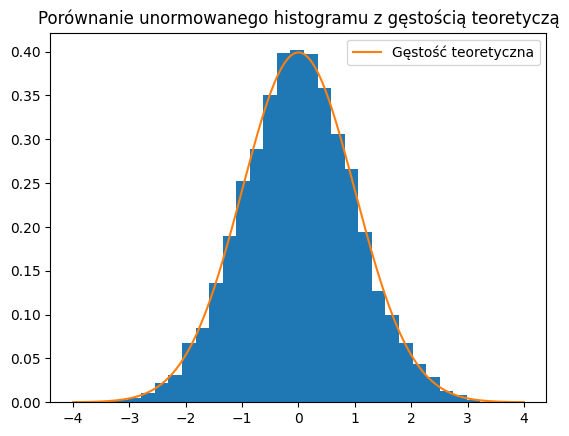

In [ ]:
sample_inv_cdf = norm_inv_cdf(n_norm, mi, sigma)
plt.hist(sample_inv_cdf, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

Następnie porównajmy dystrybuantę empiryczną otrzymanego rozkładu z dystrybuantą teoretyczną rozkładu $N(0,1)$

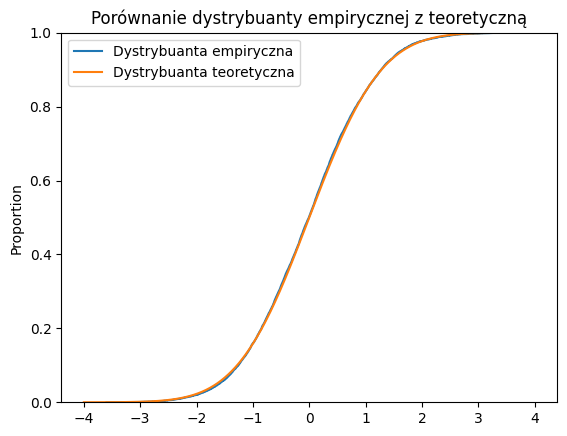

In [ ]:
sns.ecdfplot(sample_inv_cdf, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Unormowany histogram dobrze wypełnia funkcję gęstości szukanego rozkładu, a dystrybuanta empiryczna niemalże idealnie pokrywa się z dystrybuatą teoretyczną, stąd możemy stwierdzić, że użyta metoda działa poprawnie. O jej dokładności i efektywności lepiej przekonamy się w dalszej części.

### Metoda akceptacji-odrzucenia

Kolejna metoda opiera się na zmiennych wygenerowanych z rozkładu wykładniczego, a więc możemy ją zastosować, jeśli najpierw będziemy dysponować zmiennymi z tego właśnie rozkładu.

Rozpoczniemy od wygenerowania $Y$ mający rozkład wykładniczy $Exp(1)$. Gęstość Y to
$$
g(x) = e^{-x}
$$
dla $x \ge 0$. 

Na początku rozważamy $|X|$ o rozkładzie półnormalnym, którego gęstość wynosi $2\cdot\phi(x)$:
$$
f(x) = \frac{\sqrt{2}}{\sqrt{\pi}}e^{\frac{-x^2}{2}}
$$
Później otrzymamy $X$ z $|X|$ generując znak $\pm 1$ z prawdopodobieństwem $\frac{1}{2}$.

Obliczymy c
$$
c =  \max_{x \in \mathbb{R}} \frac{f(x)}{g(x)} = \max_{x \in \mathbb{R}}\frac{\sqrt{2}}{\sqrt{\pi}}e^{(\frac{-x^2}{2} + x)}
$$
Policzmy pochodną wyrażenia $\frac{f(x)}{g(x)}$
$$
\frac{d}{dt}\frac{\sqrt{2}}{\sqrt{\pi}}e^{(\frac{-x^2}{2} + x)} = \frac{\sqrt{2}}{\sqrt{\pi}}(-x + 1)e^{(\frac{-x^2}{2} + x)}
$$
I przyrównując ją do zera otrzymujemy punkt $x =1$. 

Zatem dostajemy 
$$
c = \frac{\sqrt{2}}{\sqrt{\pi}}e^{(\frac{-1}{2} + 1)} = \sqrt{\frac{2e}{\pi}}
$$
I mamy też 
$$
\frac{f(x)}{cg(x)} = e^{\frac{-(x-1)^2}{2}}
$$

$Y$ będziemy mogli wygenerować za pomocą metody odwracania dystrybuanty. Po wygenerowaniu $|X|$, wylosujemy znak $X$. W tym momencie będziemy już mieli rozkład standardowy normalny. By uzyskać rozkład $N(\mu, \sigma)$, będziemy mogli przekształcić $X$, by otrzymać uogólnione $Z = \sigma X + \mu$.

In [ ]:
def exp_simulation(num, lambda_): #generowanie rozkładu wykładniczego metodą odwrotnej dystrybuanty
    sample = np.random.rand(num)
    return (-1)/lambda_ * np.log(1-sample)

In [ ]:
def norm_using_exp(n, mi=0, sigma=1):
    samples = []
    sigmas = [1/sigma] * n
    mis = [mi] * n
    while len(samples) < n:
        y = exp_simulation(1,1)[0]
        u = np.random.uniform()
        if u <= np.exp(-(y-1)**2/2):
            u2 = np.random.uniform()
            if u2 < 0.5:
                samples.append(y)
            else:
                samples.append(-y)
    return np.add(np.multiply(samples,sigmas), mis)
    

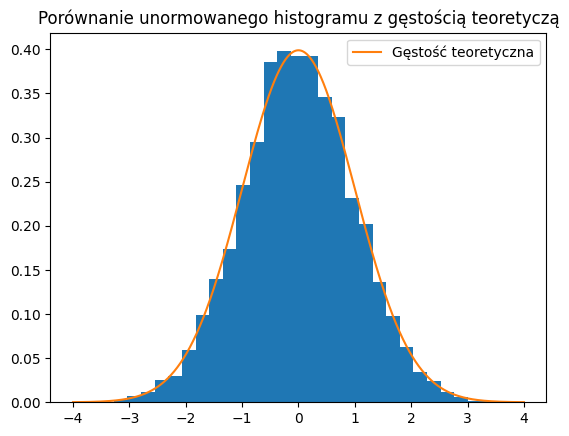

In [ ]:
sample_using_exp = norm_using_exp(n_norm, mi, sigma)
plt.hist(sample_using_exp, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

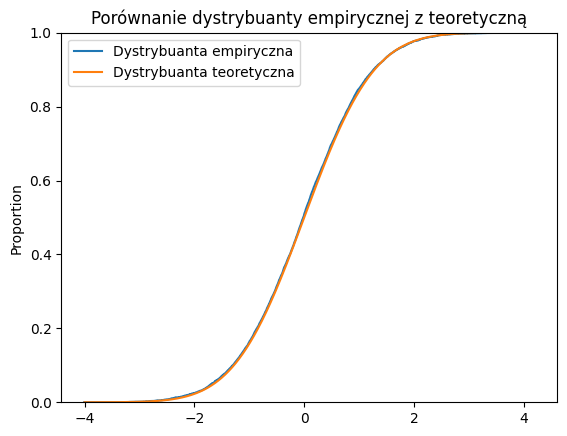

In [ ]:
sns.ecdfplot(sample_using_exp, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Histogram dobrze wypełnia obszar pod krzywą gęstości, a dystrybuanta empiryczna pokrywa się z teoretyczną, więc metodę można uznać za poprawną.

### Metoda stosunków jednostajnych

Ta metoda wykorzystuje zmienne losowe wygenerowane z rozkładu jednostajnego. Założmy, że szukamy pewnej zmiennej losowej $Z$, której gęstość $f$ znamy z dokładnością do pewnego stałego czynnika $c$, a zatem $f(x) = c \cdot h(x)$. Wówczas wykonujemy następujące kroki

1. Generujemy parę $X$, $Y$ z rozkładu jednostajnego na zbiorze {${(x,y): 0\le x \le \sqrt{h(y/x)}}$}
2. Zwracamy $Z = Y/X$

I mamy zmienną $Z$ o szukanym rozkładzie wyznaczonym przez gęstość $f$

In [ ]:
def ratio_of_uniforms(n,mi=0, sigma=1):
    lista_x = []
    lista_y = []
    sigmas = [1/sigma] * n
    mis = [mi] * n
    while len(lista_x) < n:
        x_losowy = random.uniform(0,1)
        y_losowy = random.uniform(-1,1)
        if -2*x_losowy*np.sqrt((-1)*np.log(x_losowy))<y_losowy<2*x_losowy*np.sqrt((-1)*np.log(x_losowy)):
            lista_x.append(x_losowy)
            lista_y.append(y_losowy)
    arr1 = np.array(lista_x)
    arr2 = np.array(lista_y)
    odp = arr2/arr1
    return np.add(np.multiply(odp,sigmas), mis)


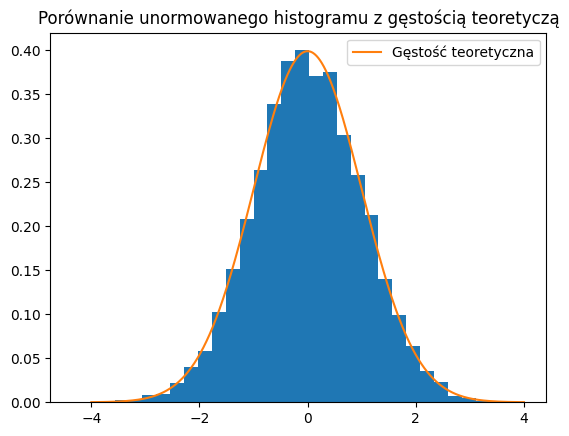

In [ ]:
sample_ratio_of_uni = ratio_of_uniforms(n_norm,mi, sigma)
plt.hist(sample_ratio_of_uni, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

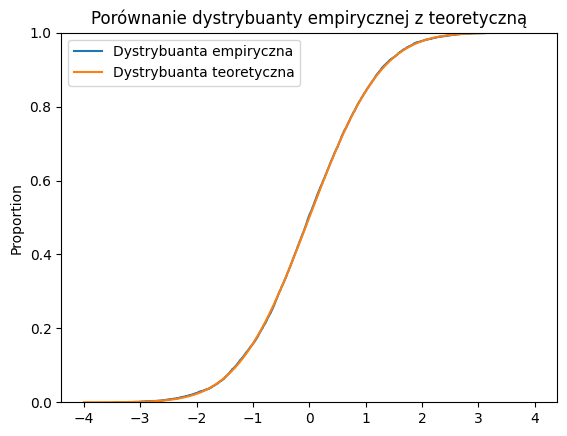

In [ ]:
sns.ecdfplot(sample_ratio_of_uni, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Unormowany histogram zgadza się z gęstością szukanego rozkładu, a dystrybuanta empiryczna doskonale pokrywa dystrybunatę teoretyczną rozkładu normalnego. Metoda jest poprawna

### Metoda Boxa-Mullera

Metoda Boxa-Mullera wykorzystuje liczby pseudolosowe, które łatwo możemy wygenerować. Chcemy dostać parę zmiennych losowych $Y_1$ i $Y_2$ z rozkładu $N(\mu, \sigma)$.

Dysponujemy zmiennymi $U_1$ i $U_2$ z rozkładu jednostajnego $U(0,1)$. Wykonujemy kroki

1. Niech $a = \sqrt{-2\ln{(U_1)}}$ i $b=2\pi U_2$.
2. Niech $X_1 = a\sin{(b)}$ i $X_2 = a\cos{(b)}$
3. Zwracamy $Y_1 = \sigma X_1 + \mu$ oraz $Y_2 = \sigma X_1 + \mu$

In [ ]:
def box_muller(n, mu=0, sigma=1):
    m1 = [mu] * n
    s1 = [sigma] * n
    samples = []
    while len(samples) < n:
        u = np.random.random()
        v = np.random.random()
        r = np.sqrt(-2 * np.log(u))
        theta = 2 * np.pi * v
        samples.append(r * np.cos(theta))
        samples.append(r * np.sin(theta))
    return np.add(np.multiply(samples, s1), m1)

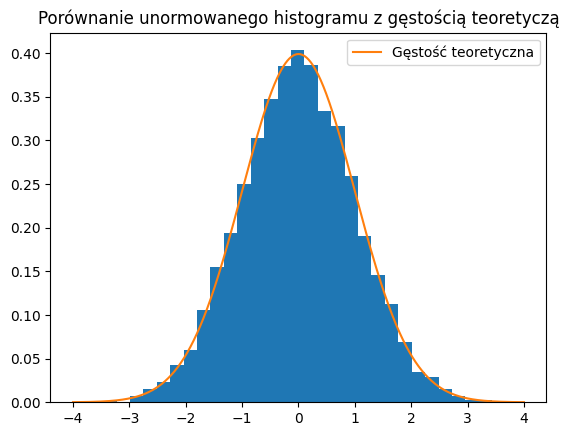

In [ ]:
sample_box_muller = box_muller(n_norm, mi, sigma)
plt.hist(sample_box_muller, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

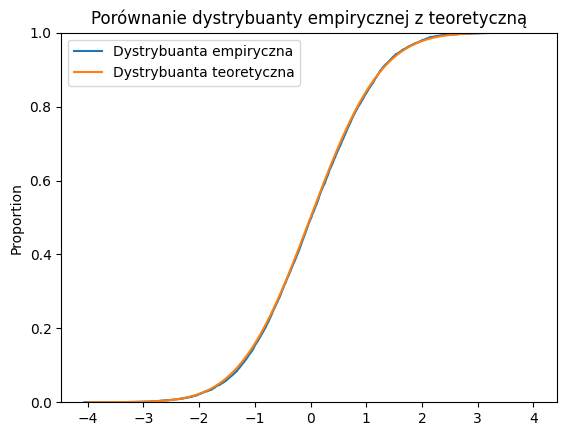

In [ ]:
sns.ecdfplot(sample_box_muller, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Unormowany histogram i dystrybuanta empirycznna są zgodne odpowiednio z gęstością i dystrybuantą teoretyczą szukanego rozkładu, więc metoda działa prawidłowo.

### Metoda Marsaglii

Metoda Marsaglii wykorzystuje zmienne losowe z rozkładu jednostajnego $U(-1,1)$, które łatwo wygenerujemy chociażby metodą odwrotnej dystrybuanty na liczbach pseudolosowych.

Wykonujemy kroki

1. Generuj $Y_1$ i $Y_2$ z rozkładu $U(-1,1)$
2. Sprawdź, czy $r=Y_1^2 + Y_2^2 < 1$, jeśli nie - wróć do 1.
3. Niech $Y = \sqrt{-2\ln{(r)}/r}$
4. Niech $X_1 = Y_1 \cdot Y$ i $X_2 = Y_2 \cdot Y$
5. Zwróć $Z_1 = \sigma X_1 + \mu$ oraz $Z_2 = \sigma X_1 + \mu$

In [ ]:
def marsaglia(n, mi=0, sigma=1):
    sigmas = [sigma] * n
    mis = [mi] * n
    samples = []
    while len(samples) < n:
        y1, y2 = np.random.uniform(-1,1,2)
        r = y1**2 + y2**2
        if r < 1:
            y = np.sqrt(-2*np.log(r)/r)
            x1, x2 = y1 * y, y2 * y
            samples.append(x1)
            samples.append(x2)
    return np.add(np.multiply(samples,sigmas), mis)

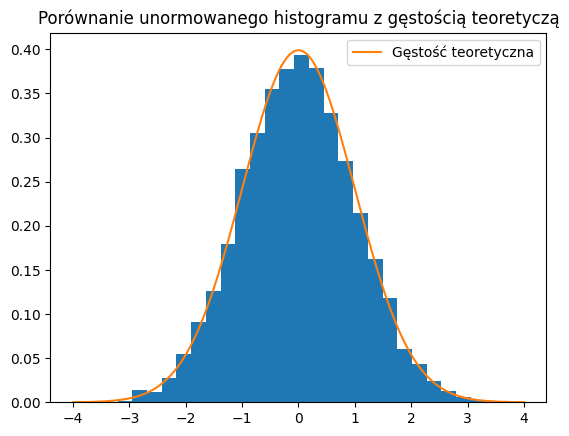

In [ ]:
sample_marsaglia = marsaglia(n_norm, mi, sigma)
plt.hist(sample_marsaglia, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

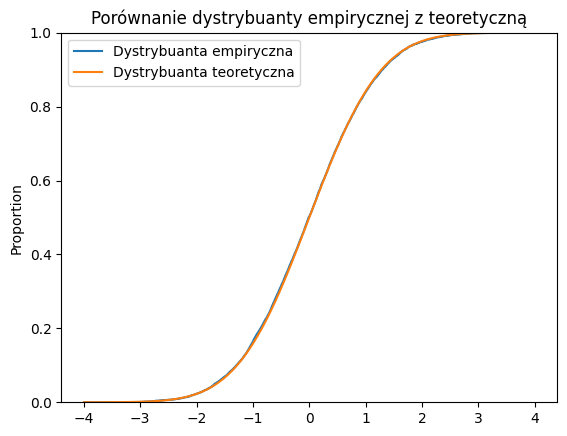

In [ ]:
sns.ecdfplot(sample_marsaglia, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

W tym wypadku również oba wykresy zgadzają się z naszymi oczekiwaniami, więc metoda jest poprawna.

### Metoda "Tuzina"

Metoda tuzina wykorzystuje liczby pseudolosowe $U(0,1)$. Wykonujemy kroki

1. Generuj $U_1, \dots , U_{12}$ z rozkładu $U(0,1)$.
2. Niech $S = \sum_{i=1}^{12} U_i$
3. Niech $X = S - 6$
4. Zwracamy $Y = \sigma X + \mu$


In [ ]:
def dozen(n, mi=0, sigma=1):
    s = [np.sum(np.random.rand(12)) for i in range(n)]
    xs = np.subtract(s, 6*np.ones(n))
    ys = np.add(np.multiply(xs, sigma*np.ones(n)), mi*np.ones(n))
    return ys

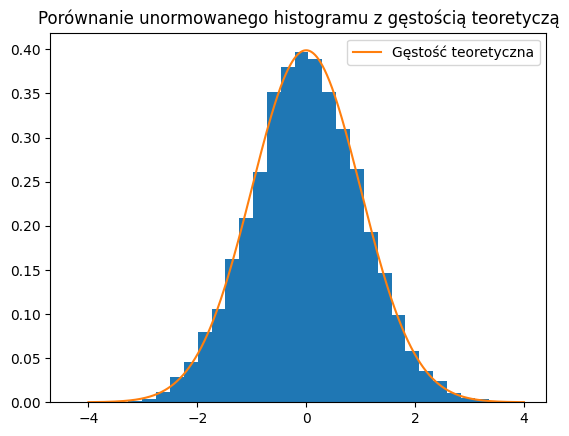

In [ ]:
sample_dozen = dozen(n_norm, mi, sigma)
plt.hist(sample_dozen, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

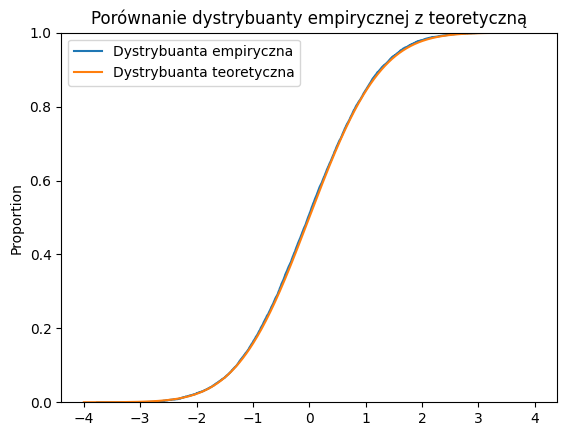

In [ ]:
sns.ecdfplot(sample_dozen, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Wykresy potwierdzają poprawność metody - podobnie jak w poprzednich przypadkach.

### Metoda Zigguratu

In [ ]:
r = 3.442619855899
v = 9.91256303526217e-3

Do metody zigguratu również będziemy potrzebować tylko zmiennych z rozkładu $U(0,1)$.  Opiera się ona na podziale funkcji gęstości prawdopodobieństwa rozkładu normalnego na prostokątne warstwy - tzw. schodki. Poniżej znajduje się funkcja `layers` ustalająca schodki. Odpowiedni wybór warstw jest niezwykle istotny, ponieważ przyczynia się do znacznego zwiększenia wydajności programu.

In [ ]:
def layers(n=256):
    # r jest granicą warstwy, powyżej której stosujemy odrzucenie i ponowne losowanie
    r = 3.442619855899
    
    # v jest początkową wartością dla obliczeń
    v = 9.91256303526217e-3

    # Inicjalizacja tablic xs i ys o odpowiednich rozmiarach
    xs = np.zeros(n + 1)
    ys = np.zeros(n)

    # Ustawienie wartości początkowych na krawędziach
    xs[0] = r
    xs[-1] = 0

    # Obliczanie wartości xs dla wszystkich warstw
    for i in range(1, n):
        xs[i] = np.sqrt(-2 * np.log(v / xs[i - 1] + np.exp(-0.5 * xs[i - 1]**2)))

    # Obliczanie wartości ys jako funkcji gęstości prawdopodobieństwa dla xs
    ys = np.exp(-0.5 * xs**2)

    return xs, ys

Posiadamy już ustalone schodki, zatem możemy zacząć generowanie zmiennych. Proces zaczyna się od wybrania losowej liczby w jednym z prostokątów. Jeśli znajduje się ona w obszarze pod krzywą gęstości - zostaje zaakceptowana, w przeciwnym wypadku generowana jest nowa próbka.

Zapiszmy poszczególne kroki

1. Wybieramy losowo warstwę $i \in (0, n)$ i generujemy $U_0$ z rozkładu $U(-1,1)$
2. Niech $x = U_0x_i$
3. Jeśli $|U| < y_i/y_{i+1}$, to zwróć $x$
4. Jeśli $i == 0$, to wykonuj
    * Generuj $U_1$, $U_2$ z rozkładu $U(0,1)$
    * Niech $x = -\ln{(U_1)}/r$ oraz $y=-\ln{(U_2)}$
    * Jeśli $2y > x^2$ - zwróć $x$ lub $-x$ w zależności od znaku $U_0$
    * W przeciwnym wypadku wróć do 4.
5. Generuj $U_1$ i weź $y = y_i + U_1(y_{i+1} - y_i)$
6. Generuj $U_2$ i sprawdź $U_2 < \exp{(-x^2/2)} / y$
7. Jeśli tak - zwróć $x$, w przeciwnym wypadku wróć do 1.

In [ ]:
def ziggurat(num, xs, ys):
    n = len(xs) - 1
    sample = np.zeros(num)
    exp_counter = 0
    ind = 0
    while ind < num:
        while True:
            i = np.random.randint(0, n)
            u = np.random.uniform(-1, 1)
            x = u * xs[i]
            if np.abs(u) < ys[i] / ys[i + 1]:
                sample[ind] = x
                ind += 1
                break
            if i == 0:
                while True:
                    u1, u2 = np.random.rand(2)
                    x = -np.log(u1) / r
                    y = -np.log(u2)
                    exp_counter += 2
                    if 2 * y > x**2:
                        if u < 0:
                            sample[ind] = x  
                            ind += 1
                            break
                        else:
                            sample[ind] = -x  
                            ind += 1
                            break
                break
            u1 = np.random.uniform()
            y = ys[i] + u1 * (ys[i + 1] - ys[i])
            exp_counter += 1
            if np.random.uniform() < np.exp(-0.5 * x**2) / y:
                sample[ind] = x
                ind += 1
                break
    return sample, exp_counter



/tmp/ipykernel_34/2234062911.py:18: RuntimeWarning: invalid value encountered in sqrt
  xs[i] = np.sqrt(-2 * np.log(v / xs[i - 1] + np.exp(-0.5 * xs[i - 1]**2)))


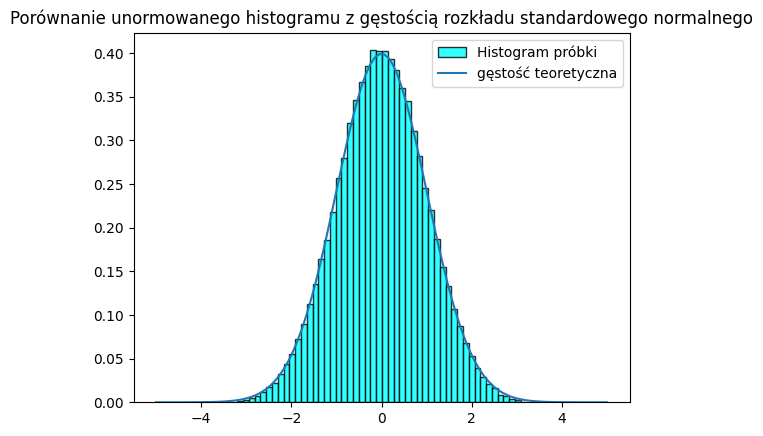

In [ ]:
xs_, ys_ = layers()
sample_ziggurat = ziggurat(100000, xs_, ys_)[0]
xs = np.linspace(-5,5, 100)
plt.hist(sample_ziggurat, bins=50, density=True, alpha=0.8, color='cyan', edgecolor='black', label="Histogram próbki")
plt.plot(xs, norm.pdf(xs, 0, 1), label="gęstość teoretyczna")
plt.title("Porównanie unormowanego histogramu z gęstością rozkładu standardowego normalnego")
plt.legend(loc='best')
plt.show()

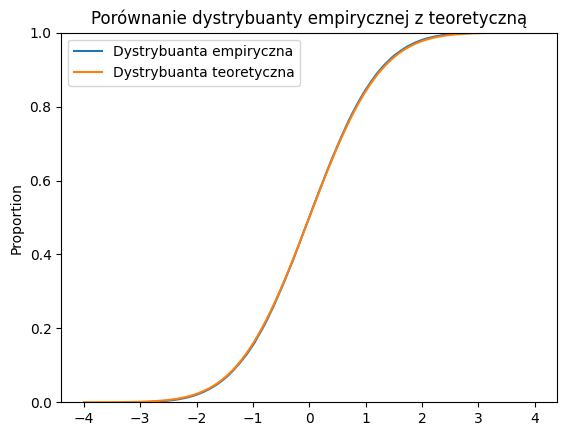

In [ ]:
sns.ecdfplot(sample_ziggurat, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Wykresy zgadzają się z gęstością i dystrybuantą rozkładu normalnego, więc metoda działa poprawnie.

Możemy także sprawdzić, jak liczba wybranych do symulacji schodków wpływa na liczbę obliczanych funkcji wykładniczych podczas symulacji. W tym celu skorzystamy z drugiej wartości zwracanej przez funkcję `ziggurat`, która wskazuje na liczbę eksponent wykorzystanych przy jednym generowaniu. Wygenerujemy próbki o równej długości, lecz różnej liczbie schodków użytych w symulacji. Dla każdego wyboru schodków symulację przeprowadziliśmy 10 razy i wyciągneliśmy średnią z obliczeń. Wyniki zaprezentowane są na poniższym wykresie.

/tmp/ipykernel_34/2224126159.py:9: RuntimeWarning: invalid value encountered in sqrt
  xs[i] = np.sqrt(-2 * np.log(v / xs[i - 1] + np.exp(-0.5 * xs[i - 1]**2)))


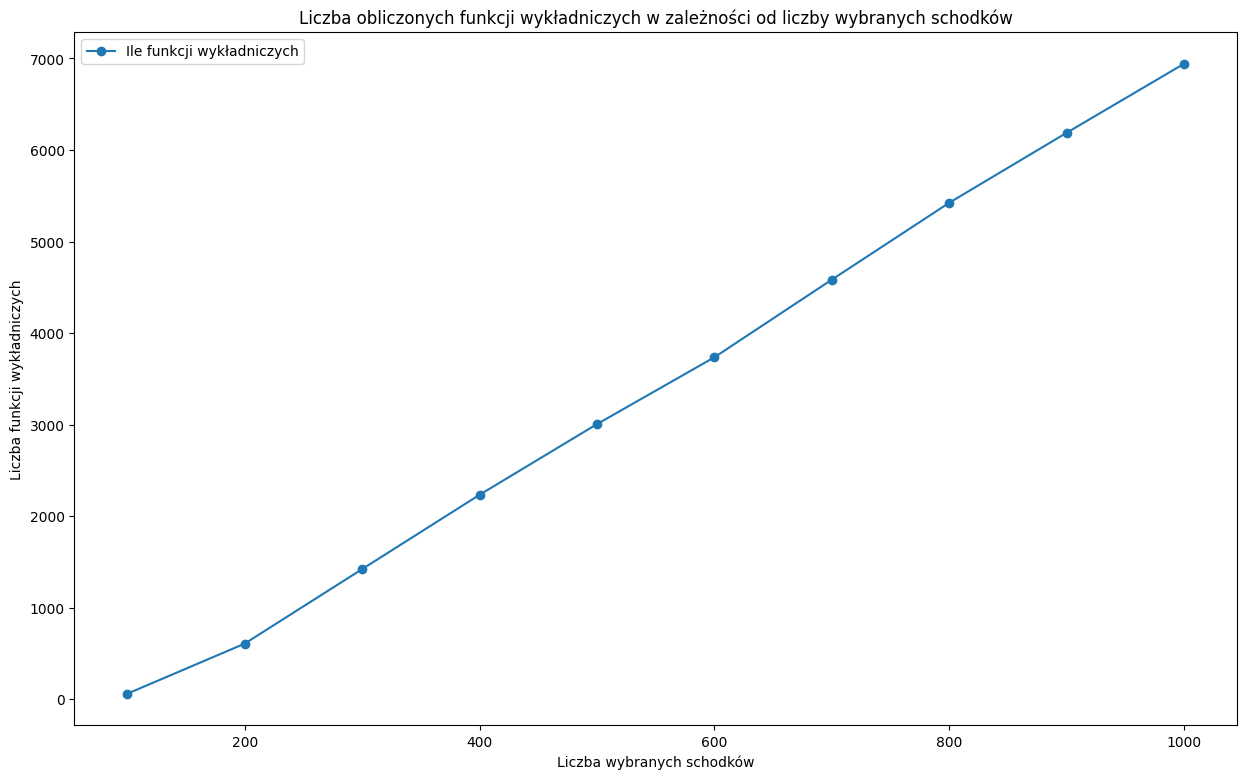

In [ ]:
nums_of_layers = np.linspace(100, 1000, 10).astype(int)
counters = np.zeros(10)
k = 10
for i in range(len(nums_of_layers)):
    count_sum = 0
    xs, ys = layers(nums_of_layers[i])
    for j in range(k):
        count_sum += ziggurat(1000, xs, ys)[1]
    counters[i] = count_sum/k
nums_list = nums_of_layers.tolist()
plt.figure(figsize=(15,9))
plt.plot(nums_list, counters, marker="o", label="Ile funkcji wykładniczych")
plt.xlabel("Liczba wybranych schodków")
plt.ylabel("Liczba funkcji wykładniczych")
plt.title("Liczba obliczonych funkcji wykładniczych w zależności od liczby wybranych schodków")
plt.legend(loc="best")
plt.show()

Jak widzimy na wykresie, liczba obliczanych funkcji wykładniczych rośnie niemal liniowo wraz ze wzrostem liczby schodków użytych w symulacji. Dzieje się tak, ponieważ każde dodatkowe schodki dodają kolejne wartości graniczne, które wymagają obliczenia funkcji wykładniczej.

### Metoda ilorazowa

Metoda ilorazowa wykorzystuje liczby pseudolosowe z $U(0,1)$.
Wykonujemy kroki

1. Niech $u=U_1$, $e = \exp{(1)}$, $v=-\sqrt{2/e} + 2U_2\sqrt{2/e}$
2. Niech X = v/u
3. Jeśli $X^2 \le 2(3-u(4+u))$, przejdź do 6.
4. Jeśli $X^2 \le 2/u - 2u$ i $x^2 \le -4\ln{(u)}$, przejdź do 6.
5. Wróc do 1.
6. Zwróć $Y = \sigma X + \mu$

In [ ]:
def iloraz(n, mi=0, sigma=1):
    ys = np.zeros(n)
    i = 0
    while i < n:
        u1, u2 = np.random.rand(2)
        u, e = u1, np.exp(1)
        v = -np.sqrt(2/e) + 2*np.sqrt(2/e) * u2
        x = v/u
        if x**2 <= 2*(3 - u*(4 + u)):
            ys[i] = sigma * x + mi
            i += 1
        elif x**2 <= 2/u - 2*u and x**2 <= -4 * np.log(u):
            ys[i] = sigma * x + mi
            i += 1
    return ys

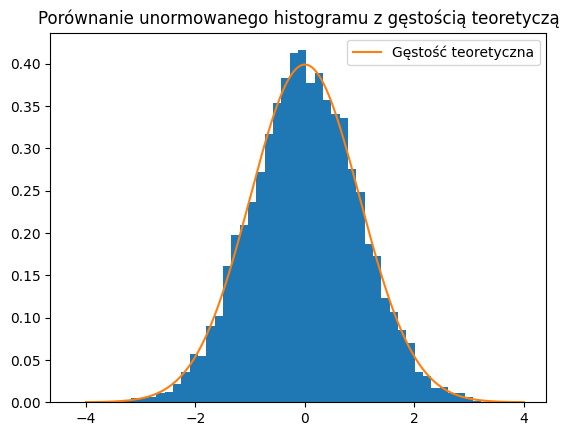

In [ ]:
sample_iloraz = iloraz(10000, mi, sigma)
plt.hist(sample_iloraz, density=True, bins=50)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

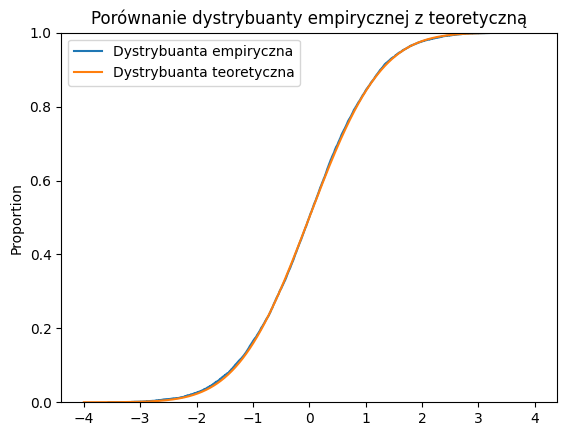

In [ ]:
sns.ecdfplot(sample_iloraz, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Wykresy zgadzają się z krzywymi charakteryzującymi rozkład normalny, więc metoda ilorazowa jest poprawna.

### Generator Levy

Generator Levy'ego potrzebuje jedynie wygenerowanych $U_1$ i $U_2$ z rozkładu $U(0,1)$. 

Następnie wykonujemy kroki

1. Niech $e=\exp{(1)}$, $a=0.196$, $b=0.25472$, $ss=0.449871$, $t=-0.386595$
2. Niech $u=U_1$, $v=-\sqrt{2/e} + 2U_2\sqrt{2/e}$
3. Niech $x = u - ss$, $y = |v| - t$, $Q = x^2 + y(ay - bx)$
4. Jeśli $Q < 0.27597$ - przejdź do 7.
5. Jeśli $Q > 0.27846$ - wróć do 2.
6. Jeśli $|v| > -4u$ - wróć do 2.
7. Jeśli $v = 0$ - wróć do 2.
8. Niech $X=v/u$
9. Zwróć $Y = \sigma X + \mu$

In [ ]:
def levy(n, mi=0, sigma=1):
    ys = np.zeros(n)
    i = 0
    while i < n:
        e = np.exp(1)
        a = 0.196
        b = 0.25472
        ss = 0.449871
        t = -0.386595
        u1, u2 = np.random.rand(2)
        u = u1
        v = -np.sqrt(2/e) + 2*u2*np.sqrt(2/e)
        x = u - ss
        y = np.absolute(v) - t
        q = x**2 + y*(a*y - b*x)
        if q < 0.27597:
            if v/u != 0:
                X = v/u
                ys[i] = sigma * X + mi
                i += 1
        elif q > 0.27846:
            continue
        elif np.abs(v) <= 4 * u:
            continue
        elif v / u == 0:
            continue
        else:
            if v/u != 0:
                X = v/u
                ys[i] = sigma * X + mi
                i += 1
    return ys




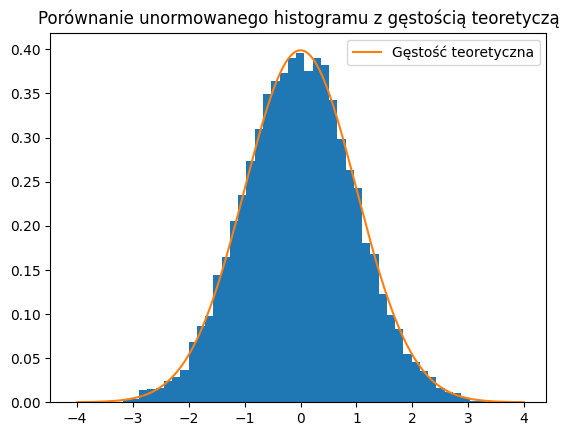

In [ ]:
sample_levy = levy(n_norm, mi, sigma)
plt.hist(sample_levy, density=True, bins=50)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

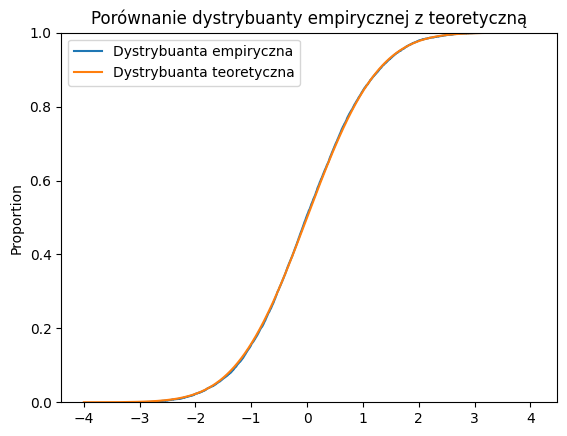

In [ ]:
sns.ecdfplot(sample_levy, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Histogram dobrze wypełnia pole pod krzywą gęstości a dystrybunaty się pokrywają - można więc stwierdzić, że generator Levy działa.

### Metoda Ahrensa-Dietera

Metoda Ahrensa-Dietera zakłada, że mamy wylosowane $U_1$, $U_2$ i $U_3$ z rozkładu $U(0,1)$. 

Potem wykonujemy kroki
1. Jeśli $U_1 < 0.5$, to $a = 1$, w przeciwnym wypadku $a=-1$
2. Niech $b=-\ln{(U_2)}$
3. Niech $c=\tan{(\pi(U_3 - 0.5))}$
4. Niech $d=\sqrt{2b/(1+c^2)}$
5. Weź $X_1 = ad$ i $X_2 = cd$
6. Zwróć $Y_1 = \sigma X_1 + \mu$ i $Y_2 = \sigma X_2 + \mu$


In [ ]:
def ahrens_dieter(n, mi=0, sigma=1):
    ys = np.zeros(n)
    i = 0
    while i < n-2:
        u1, u2, u3 = np.random.rand(3)
        if u1 < 0.5:
            a = 1
        else:
            a = -1
        b = -np.log(u2)
        c = np.tan(np.pi*(u3 - 0.5))
        d = np.sqrt(2*b/(1+c**2))
        x1,x2 = a*d, c*d
        y1, y2 = sigma * x1 + mi, sigma * x2 + mi
        ys[i], ys[i+1] = y1, y2
        i += 1
    return ys

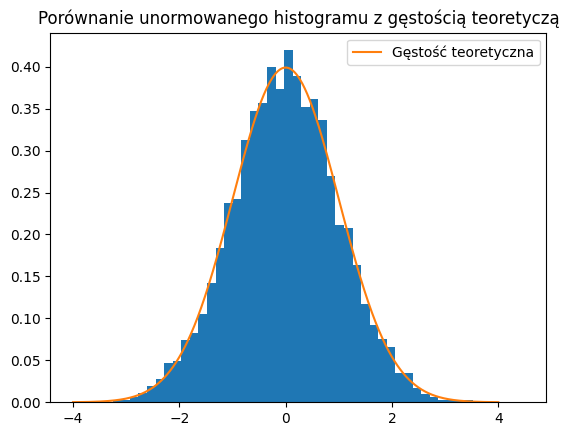

In [ ]:
sample_ahrens_dieter = ahrens_dieter(n_norm, mi, sigma)
plt.hist(sample_ahrens_dieter, density=True, bins=50)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

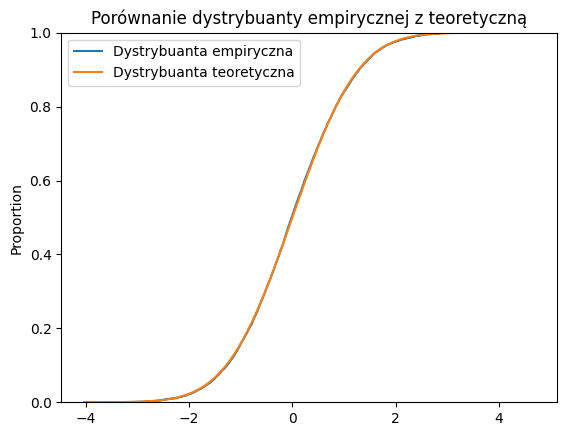

In [ ]:
sns.ecdfplot(sample_ahrens_dieter, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Histogram zgadza się z gęstością, a dystrybuanta empirycza - z teoretyczą. Oznacza to, że nasza metoda działa poprawnie.

### Metoda Grand

Ostatnią metodą, którą zaproponujemy, będzie generator Grand. 
Zakładamy, że mamy $U_1, \dots, U_6$ z rozkładu $U(0,1)$. 
Wprowadźmy też $t_i = \Phi^{-1}(1 - 2^{-i-1})$, dla $i = 0,1,2,\dots$, 
gdzie $\Phi^{-1}$ oznacza odwróconą dystrybuantę standardowego rozkładu normalnego. 

Następnie wykonujemy kroki
1. Niech $a=U_1$, $i=0$
2. Dopóki $a<0.5$ wykonuj
    * $a = 2a$
    * $i = i+1$
3. Niech $u=(t_{i+1} - t_i)U_2$, $v=u(0.5u + t_i)$
4. Jeśli $v<U_6$
    * Jeśli $U_4 < 0.5$, to $X=t_i + u$
    * W przeciwnym wypadku $X = -t_i - u$
5. Zwróć $Y=\sigma X + \mu$


In [ ]:
def phi_inv(x):
    return np.sqrt(-np.log(x**2))

In [ ]:
def grand(n, mi=0, sigma=1):
    ys = np.zeros(n)
    ind = 0
    while ind < n:
        u1,u2,u3,u4,u5,u6 = np.random.rand(6)
        a = u1
        i = 0
        while a < 0.5:
            a *= 2
            i += 1
        t_i = norm.ppf(1 - 2**(-i-1))
        t_i1 = norm.ppf(1 - 2**(-(i+1)-1))
        u = (t_i1 - t_i) * u2
        v = u * (0.5 * u + t_i)
        if v < u6:
            if u4 < 0.5:
                X = t_i + u
            else:
                X = -t_i - u
            ys[ind] = sigma * X + mi
            ind += 1
    return ys


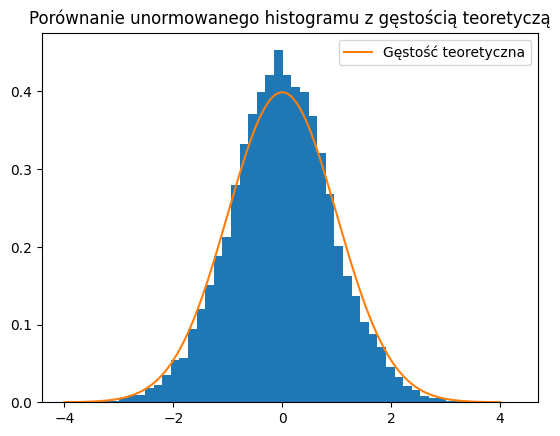

In [ ]:
sample_grand = grand(10000, mi, sigma)
plt.hist(sample_grand, density=True, bins=50)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

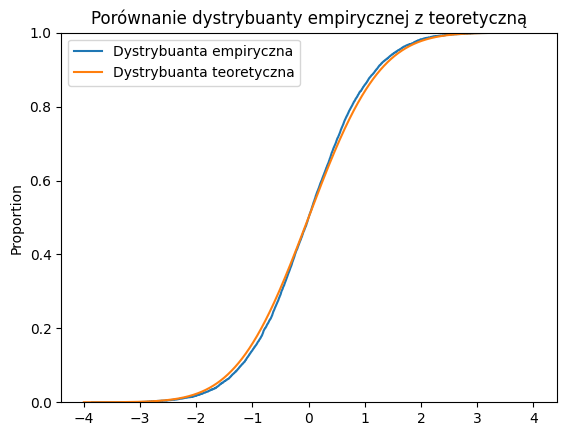

In [ ]:
sns.ecdfplot(sample_grand, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Histogram najsłabiej dopasowuje się do krzywej gęstości ze wszystkich poprzednich przypadków. Dystrybuanta empiryczna w większości pokrywa się z teoretyczną, choć są momenty, gdzie ich wartości od siebie mocniej odbiegają. Może to sugerować, że w implementacji istnieje drobny błąd, który obniża dokładność algorytmu, ale w dalszym ciągu próbka w większości pochodzi z rozkładu normalnego.

## Test efektywności 

Następnym bardzo istotnym krokiem będzie sprawdzenie efektywności działania przedstawionych metod. W tym celu policzymy czas generowania próbek o długościach $1000, 2000, \dots, 10 000$ za pomocą każdego generatora i porównamy czasy na jednym wykresie.

Funkcja `time_check` odpowiada za liczenie czasu działania programu dla każdej długości.

In [ ]:

def time_check(func, ns, mi, sigma):
    times = np.zeros(len(ns))
    if func.__name__ == "ziggurat":
        for i in range(len(ns)):
            start = time.time()
            ziggurat(ns[i], xs_, ys_)
            end = time.time()
            times[i] = end - start
    else:
        for i in range(len(ns)):
            start = time.time()
            func(ns[i], mi, sigma)
            end = time.time()
            times[i] = end - start
    return times

In [ ]:
ns = np.linspace(1000, 10000, 10).astype(int)

Tworzymy tablice czasów za pomocą `time_check`.

In [ ]:
times_inv_cdf = time_check(norm_inv_cdf, ns, mi, sigma)
times_using_exp = time_check(norm_using_exp, ns, mi, sigma)
times_ratio_of_uniforms = time_check(ratio_of_uniforms, ns, mi, sigma)
times_box_muller = time_check(box_muller, ns, mi, sigma)
times_ziggurat = time_check(ziggurat, ns, mi, sigma)
times_marsaglia = time_check(marsaglia, ns, mi, sigma)
times_dozen = time_check(dozen, ns, mi, sigma)
times_iloraz = time_check(iloraz, ns, mi, sigma)
times_levy = time_check(levy, ns, mi, sigma)
times_ahrens_dieter = time_check(ahrens_dieter, ns, mi, sigma)
#times_grand = time_check(grand, ns, mi, sigma)

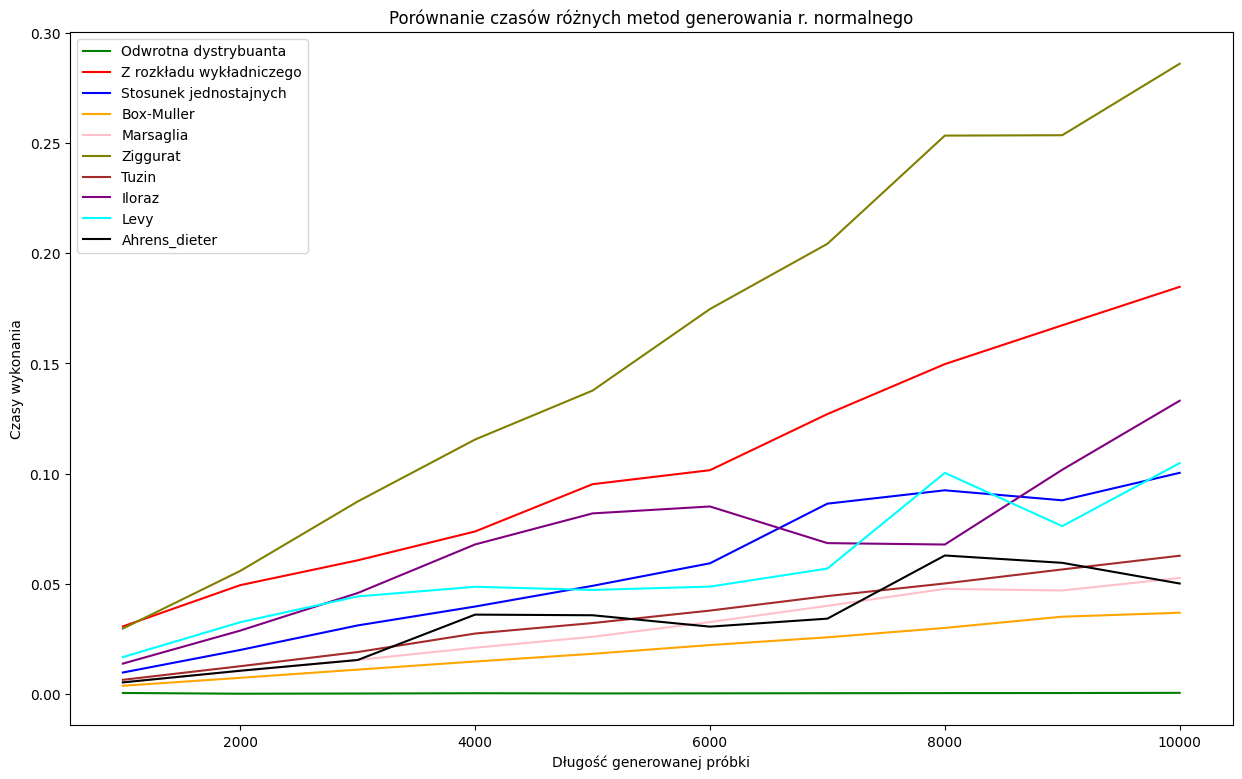

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(ns, times_inv_cdf, c="g", label="Odwrotna dystrybuanta")
plt.plot(ns, times_using_exp, c="r", label="Akceptacji-odrzucenia")
plt.plot(ns, times_ratio_of_uniforms, c="b", label="Stosunek jednostajnych")
plt.plot(ns, times_box_muller, c="orange", label="Box-Muller")
plt.plot(ns, times_marsaglia, c="pink", label="Marsaglia")
plt.plot(ns, times_ziggurat, c="olive", label="Ziggurat")
plt.plot(ns, times_dozen, c="brown", label="Tuzin")
plt.plot(ns, times_iloraz, color="purple", label="Iloraz")
plt.plot(ns, times_levy, color="cyan", label="Levy")
plt.plot(ns, times_ahrens_dieter, color="black", label="Ahrens_dieter")
#plt.plot(ns, times_grand, color="y", label="Grand")
plt.ylabel("Czasy wykonania")
plt.xlabel("Długość generowanej próbki")
plt.title("Porównanie czasów różnych metod generowania r. normalnego")
plt.legend(loc="best")
plt.show()


Jak widzimy, najlepszą wydajnością czasową charakteryzuje się metoda odwrotnej dystrybunaty, która zdaje się być prawie niewrażliwa na długość próbki. Powodem tego jest niezwykła prostota kodu (brak dodatkowych obiektów zajmujących pamięć, zmiennych, pętli) i wektoryzacja wszystkich obliczeń. Zaraz za nią znajduje się metoda Boxa-Mullera, która jest tylko odrobinę wolniejsza. Najwolniejsze okazały się metoda akcpetacji-odrzucenia i zigguratu (bazująca na metodzie akcpetacji-odrzucenia). Na wykresie nie uwzględiliśmy metody Granda, ponieważ jest ona na tyle wolna, że przedstawiona na wykresie z pozostałymi, znacząco zwiększa skalę. Wykryty przy generowaniu histogramu błąd w implementacji także może przekładać się na jego wydajność.

### Test Kołmogorowa-Smirnowa

Celem dokładnego sprawdzenia pochodzenia generowanej próbki, wykonaliśmy test Kołmogorowa-Smirnowa, który jednozacznie określa, czy uzyskana próbka pochodzi z rozkładu normalnego. Metoda ta wykorzystuje obliczanie różnić między dystrybuantą empiryczną $F_n(x)$ wygenerowanej próbki, a dystrybuatą teoretyczną $F(x)$ spodziewanego rozkładu. Statystyka testu Kołmogorowa-Smirnowa (K-S statystyka) jest określona jako 

$$ D_n = \sup_{x}|F_n(x) - F(x)| $$ 
 
Można też go wykorzystać do sprawdzenia, czy dwie próbki należą do tego samego rozkładu. Wówczas obliczane są różnice między ich dystrybuantami empirycznymi. Test przewiduje następujące hipotezy

* Hipoteza zerowa (H_0): Próbka pochodzi z danego rozkładu (lub dwie próbki pochodzą z tego samego rozkładu)
* Hipoteza alternatywna (H_1): Próbka nie pochodzi ze wskazanego rozkładu (lub próbki pochodzą z różnych rozkładów)

O przyjęciu hipotezy zerowej H_0 lub odrzuceniu jej na rzecz alternatywnej H_1 decyduje p-wartość testu. Przyrównuje się ją do ustalonego progu istotności $\alpha$. Wówczas 

* p-wartość $> \alpha$ potwierdza hipotezę zerową
* p-wartość $< \alpha$ odrzuca hipotezę zerową, na rzecz hipotezy alternatywnej

In [ ]:
from scipy.stats import kstest

In [ ]:
ns2 = [1000, 5000, 10000]


Funkcja `kolmogorow_smirnow` oblicza statystykę testu oraz p-wartość dla każdej metody.

In [ ]:
def kolmogorow_smirnow(func, ns, mi=0, sigma=1):
    stats, pvalues = np.zeros(len(ns)), np.zeros(len(ns))
    for i in range(len(ns)):
        if func.__name__ == "ziggurat":
            sample = ziggurat(ns[i], xs_,ys_)[0]
            stat, pvalue = kstest(sample, "norm", args=(mi, sigma))
            stats[i], pvalues[i] = round(stat,5), round(pvalue,5)
        else:
            sample = func(ns[i], mi, sigma)
            stat, pvalue = kstest(sample, "norm", args=(mi, sigma))
            stats[i], pvalues[i] = round(stat,5), round(pvalue,5)
    return stats, pvalues

Przetestujmy nasze metody dla trzech różnych wielkości próbek $N_1 = 1000$, $N_2 = 5000$, $N=10 000$. Odpowiedni dobór wielkości próbek jest ważny w teście Kołmogorowa-Smirnowa, ponieważ przyjmuje się, że jest on wiarygodny tylko dla dużych próbek (w zależności od źródła jako granicę można znaleźć ($N=1000$ lub $N=2000$)

In [ ]:
stats_inv_cdf, pvalues_inv_cdf = kolmogorow_smirnow(norm_inv_cdf, ns2)
stats_using_exp, pvalues_using_exp = kolmogorow_smirnow(norm_using_exp, ns2)
stats_ratio_o_u, pvalues_ratio_o_u = kolmogorow_smirnow(ratio_of_uniforms, ns2)
stats_bm, pvalues_bm = kolmogorow_smirnow(box_muller, ns2)
stats_marsaglia, pvalues_marsaglia = kolmogorow_smirnow(marsaglia, ns2)
stats_ziggurat, pvalues_ziggurat = kolmogorow_smirnow(ziggurat, ns2)
stats_dozen, pvalues_dozen = kolmogorow_smirnow(dozen, ns2)
stats_iloraz, pvalues_iloraz = kolmogorow_smirnow(iloraz, ns2)
stats_levy, pvalues_levy = kolmogorow_smirnow(iloraz, ns2)
stats_ad, pvalues_ad = kolmogorow_smirnow(ahrens_dieter, ns2)
stats_grand, pvalues_grand = kolmogorow_smirnow(grand, ns2)



In [ ]:
for i in range(len(ns2)):
    print(f"Wielkość próbki n = {ns2[i]}:")
    
    print(f"Metoda odwrotnej dystrybuanty - Statystyka K-S: {stats_inv_cdf[i]}, P-wartość: {pvalues_inv_cdf[i]}")
    print(f"Metoda akceptacji-odrzucenia - Statystyka K-S: {stats_using_exp[i]}, P-wartość: {pvalues_using_exp[i]}")
    print(f"Metoda stosunku jednostajnych - Statystyka K-S: {stats_ratio_o_u[i]}, P-wartość: {pvalues_ratio_o_u[i]}")
    print(f"Metoda Boxa-Mullera - Statystyka K-S: {stats_bm[i]}, P-wartość: {pvalues_bm[i]}")
    print(f"Metoda Marsaglii - Statystyka K-S: {stats_marsaglia[i]}, P-wartość: {pvalues_marsaglia[i]}")
    print(f"Metoda zigguratu - Statystyka K-S: {stats_ziggurat[i]}, P-wartość: {pvalues_ziggurat[i]}")
    print(f"Metoda tuzina - Statystyka K-S: {stats_dozen[i]}, P-wartość: {pvalues_dozen[i]}")
    print(f"Metoda ilorazu - Statystyka K-S: {stats_iloraz[i]}, P-wartość: {pvalues_iloraz[i]}")
    print(f"Metoda Levy - Statystyka K-S: {stats_levy[i]}, P-wartość: {pvalues_levy[i]}")
    print(f"Metoda Ahrensa-Dietera - Statystyka K-S: {stats_ad[i]}, P-wartość: {pvalues_ad[i]}")
    print(f"Metoda Granda - Statystyka K-S: {stats_grand[i]}, P-wartość: {pvalues_grand[i]}")

    print("--------------------------------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------------------------------")

Wielkość próbki n = 1000:
Metoda odwrotnej dystrybuanty - Statystyka K-S: 0.02165, P-wartość: 0.72819
Metoda z rozkładu wykładniczego - Statystyka K-S: 0.03627, P-wartość: 0.14043
Metoda stosunku jednostajnych - Statystyka K-S: 0.02365, P-wartość: 0.62175
Metoda Boxa-Mullera - Statystyka K-S: 0.01719, P-wartość: 0.92407
Metoda Marsaglii - Statystyka K-S: 0.02746, P-wartość: 0.43042
Metoda zigguratu - Statystyka K-S: 0.02663, P-wartość: 0.46926
Metoda tuzina - Statystyka K-S: 0.02254, P-wartość: 0.68121
Metoda ilorazu - Statystyka K-S: 0.02554, P-wartość: 0.52337
Metoda Levy'ego - Statystyka K-S: 0.01476, P-wartość: 0.97908
Metoda Ahrensa-Dietera - Statystyka K-S: 0.02963, P-wartość: 0.33702
Metoda Granda - Statystyka K-S: 0.02736, P-wartość: 0.43502
--------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------

Popularnym poziomem istotności testu Kołmogorowa-Smirnowa jest wartość $\alpha=0.05$. Przyjmując te wartość jako nasz próg, możemy stwierdzić, że wszystkie metody z wyjątkiem generatora Granda pozytywie przeszły test, a zatem wszystkie poprawnie generują próbki z rozkładu normalnego. Zobaczmy jednak, że niektóre metody cechowały się wybitną precyzją dla pewnych długości próbek 

* Metoda Boxa-Mullera charakteryzuje się bardzo dużą dokładnością (wysoka p-wartość) przy bardzo niskiej rozbieżności dystrybunaty empirycznej od teoretycznej (niska wartość K-S statystyki)
* Metoda Levy również wyróżnia się dużą precyzją
* Metodę odwrotnej dystrybuanty również należy uznać za precyzyjną, a w połączeniu z dużą efektywnością, również za bardzo przydatną

# Zadanie 5

W zadaniu piątym przeanalizujemy proces ruiny modelu Cramera-Lundberga. Jest on używany do modelowania procesów ekonomicznych zachodzących w mikroskali, np. w obrębie jednego przedsiębiorstwa. Przyjmijmy tę analogię dla lepszego zrozumienia tematu. Niech $X_t$ będzie rozważanym procesem ruiny, inaczej - budżetem pewnej firmy ubezpiczeniowej. Jest on określony wzorem

$$X_t = u + ct - \sum_{i=0}^{N_t}\xi_i$$

gdzie
* $t>0$ jest zmienną czasu
* $c>0$ jest stałą przyrostu (np. wielkością składki ubezpieczeniowej) 
* $u>0$ jest kapitałem zakładowym
* $N_t$ jest procesem Poissona o intensywości $\lambda$
* $\xi_i$ jest zmienną losową z rozkładu wykładniczego $Exp(\eta)$ (np. wielkość szkód, które musi pokryć ubezpieczalnia)



In [ ]:
def poisson_process(rate, time_duration):
    num_events = np.random.poisson(rate * time_duration)
    event_times = np.cumsum(np.random.exponential(1/rate, num_events))
    N_t = {}
    for i in range(num_events):
        N_t.update({event_times[i]:i+1})
    return num_events, event_times, N_t

In [ ]:
def proces_ruiny(eta, u, c, T, lambda_):
    num_events, event_times, N_T = poisson_process(lambda_, T)
    etas = np.random.exponential(eta, num_events)
    etas_cumsum = np.cumsum(etas)
    R = u + c*event_times - etas_cumsum
    try:
        if np.min(R) < 0:
            return 1
        else:
            return 0
    except:
        pass

## Szacowanie prawdopodobieństwa ruiny

Szczególną uwagę poświęcimy szacowaniu tzw. prawdopodobieństwa ruiny, czyli prawdopodobieństwa, że przy ustalonych parametrach firma zbankrutuje. Czasem ruiny klasycznej nazywamy zmienną $\tau = \inf${$t>0|X_t<0$}. Wówczas możemy zdefiniować prawdopodobieństwo ruiny w czasie nieskończonym jako funkcję 

$$\psi(u, c) = \mathbb{P}(\tau < \infty)$$

Prawdopodobieństwo to można jawnie wyznaczyć korzystając ze wzoru Pollaczka-Chinczyna, zgodnie z którym

$$\psi(u,c) = \frac{\eta \lambda}{c} e^{-(\frac{1}{\eta} - \frac{\lambda}{c})^u}$$

In [ ]:
def pollaczeck_khinchine(u, c, eta, lambd):
    return eta*lambd/c*np.exp(-(1/eta - lambd/c)*u)

Prawdopodobieństwo ruiny możemy także estymować dla odpowiednio dużych wartości $T$. W tym posłuży nam funkcja `ruin_prob_estim`.

In [ ]:
def ruin_prob_estim(eta, u, c, T, lambd, mc):
    if_ruin = np.zeros(mc)
    for i in range(mc):
        if_ruin[i] = proces_ruiny(eta, u, c, T, lambd)
    return sum(if_ruin)/len(if_ruin)

In [ ]:
mc = 10**3         #liczba prób Monte Carlo
u = 5              #kapitał początkowy
c = 2              #stała przyrostu          
lambd = 1          #parametr procesu Poissona
eta = 1            #parametr zmiennej xi
T1 = 10            #przykładowy horyzont czasowy
T2 = 20
T3 = 50
pc = pollaczeck_khinchine(u, c, eta, lambd)

estim1 = ruin_prob_estim(eta, u, c, T1, lambd, mc)
estim2 = ruin_prob_estim(eta, u, c, T2, lambd, mc)
estim3 = ruin_prob_estim(eta, u, c, T3, lambd, mc)

print(f"Wyestymowane prawdopodobieństwo ruiny dla T={T1}: {estim1}")
print(f"Wyestymowane prawdopodobieństwo ruiny dla T={T2}: {estim2}")
print(f"Wyestymowane prawdopodobieństwo ruiny dla T={T3}: {estim3}")
print(f"Prawdopodobieństwo ruiny ze wzoru Pollaczka-Chinczyna: {pc}")




## Analiza i wizualizacja

Następnie zajmiemy się wizualizacją trajektorii funkcji $\psi(u, c_0)$ dla ustalonych $c_0$ oraz $\psi(u_0, c)$ dla ustalonych $u_0$.

In [ ]:
u_min = 2
u_max = 10
du = 100
us = np.linspace(u_min, u_max, du)
c0_min = 2
c0_max = 4
dc0 = 5
c0s = np.linspace(c0_min, c0_max, dc0)

c_min = 1
c_max = 100
dc = 100
cs = np.linspace(c_min, c_max, dc)
u0_min = 1
u0_max = 10
du0 = 5
u0s = np.linspace(u0_min, u0_max, du0)


In [ ]:
pcs1, pcs2, pcs3, pcs4, pcs5 = pollaczeck_khinchine(us, c0s[0], eta, lambd), pollaczeck_khinchine(us, c0s[1], eta, lambd), pollaczeck_khinchine(us, c0s[2], eta, lambd), pollaczeck_khinchine(us, c0s[3], eta, lambd), pollaczeck_khinchine(us, c0s[4], eta, lambd)

Otrzymane ze wzoru Pollaczka_Chinczyna wartości porównami z wartościami wyestymowanymi za pomocą funkcji `ruin_prob_estim`.

In [ ]:
sim1 = np.zeros(du)
sim2 = np.zeros(du)
sim3 = np.zeros(du)
sim4 = np.zeros(du)
sim5 = np.zeros(du)
sim6 = np.zeros(du)
sim7 = np.zeros(du)
sim8 = np.zeros(du)
sim9 = np.zeros(du)
sim10 = np.zeros(du)
for i in range(du):
    sim1[i] = ruin_prob_estim(eta, us[i], c0s[0], 30, lambd, mc)
    sim2[i] = ruin_prob_estim(eta, us[i], c0s[1], 30, lambd, mc)
    sim3[i] = ruin_prob_estim(eta, us[i], c0s[2], 30, lambd, mc)
    sim4[i] = ruin_prob_estim(eta, us[i], c0s[3], 30, lambd, mc)
    sim5[i] = ruin_prob_estim(eta, us[i], c0s[4], 30, lambd, mc)
    sim6[i] = ruin_prob_estim(eta, u0s[0], cs[i], 30, lambd, mc)
    sim7[i] = ruin_prob_estim(eta, u0s[1], cs[i], 30, lambd, mc)
    sim8[i] = ruin_prob_estim(eta, u0s[2], cs[i], 30, lambd, mc)
    sim9[i] = ruin_prob_estim(eta, u0s[3], cs[i], 30, lambd, mc)
    sim10[i] = ruin_prob_estim(eta, u0s[4], cs[i], 30, lambd, mc)


Nanieśmy wartości na wykres i przeanalizujmy efekty

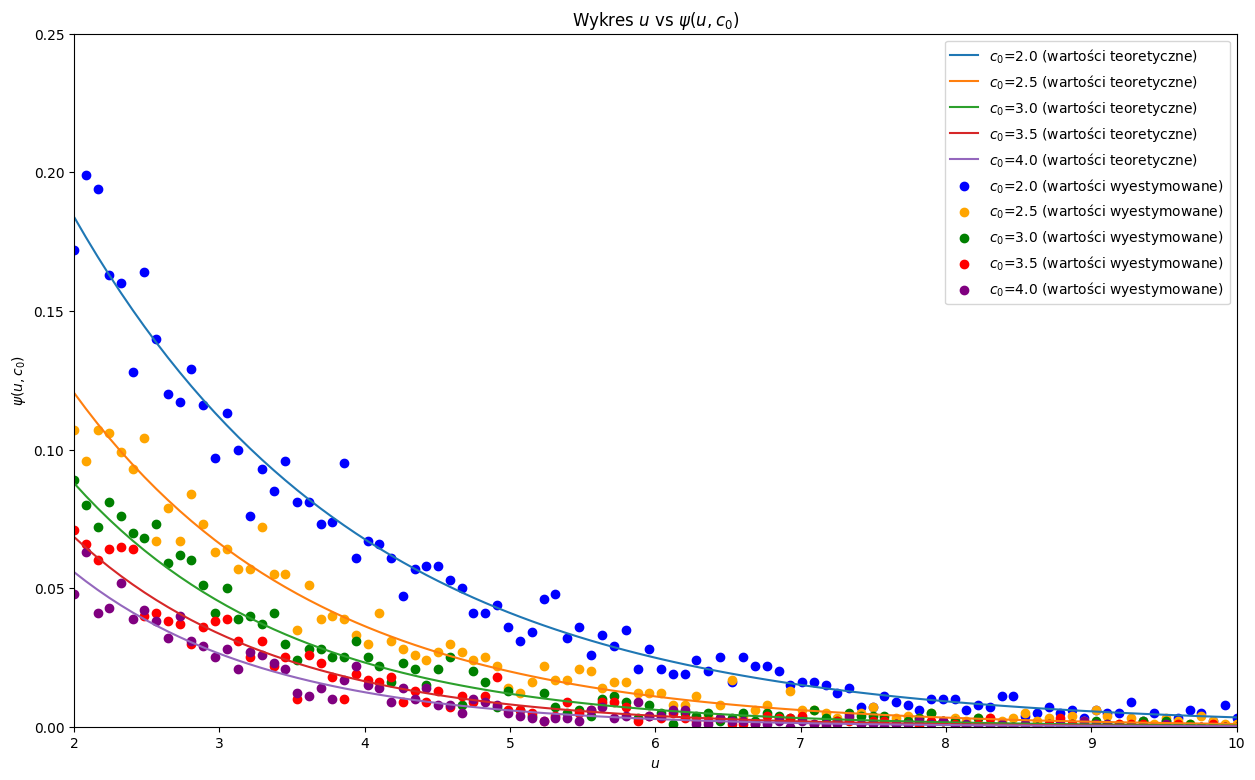

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(us, list(zip(pcs1, pcs2, pcs3, pcs4, pcs5)), label=[f"$c_0$={c0s[0]} (wartości teoretyczne)", f"$c_0$={c0s[1]} (wartości teoretyczne)", f"$c_0$={c0s[2]} (wartości teoretyczne)", f"$c_0$={c0s[3]} (wartości teoretyczne)", f"$c_0$={c0s[4]} (wartości teoretyczne)"])
plt.scatter(us, sim1, color = "blue", label= f"$c_0$={c0s[0]} (wartości wyestymowane)")
plt.scatter(us, sim2, color = "orange", label = f"$c_0$={c0s[1]} (wartości wyestymowane)")
plt.scatter(us, sim3, color = "green", label = f"$c_0$={c0s[2]} (wartości wyestymowane)")
plt.scatter(us, sim4, color = "red", label = f"$c_0$={c0s[3]} (wartości wyestymowane)")
plt.scatter(us, sim5, color = "purple", label = f"$c_0$={c0s[4]} (wartości wyestymowane)")
plt.legend(loc='best')
plt.title("Wykres $u$ vs $\psi (u, c_0)$")
plt.xlabel("$u$")
plt.ylabel("$\psi (u, c_0)$")
ax = plt.gca()
ax.set_xlim([2, 10])
ax.set_ylim([0, 0.25])
plt.show()

In [ ]:
pcs6, pcs7, pcs8, pcs9, pcs10 = pollaczeck_khinchine(u0s[0], cs, eta, lambd), pollaczeck_khinchine(u0s[1], cs, eta, lambd), pollaczeck_khinchine(u0s[2], cs, eta, lambd), pollaczeck_khinchine(u0s[3], cs, eta, lambd), pollaczeck_khinchine(u0s[4], cs, eta, lambd)

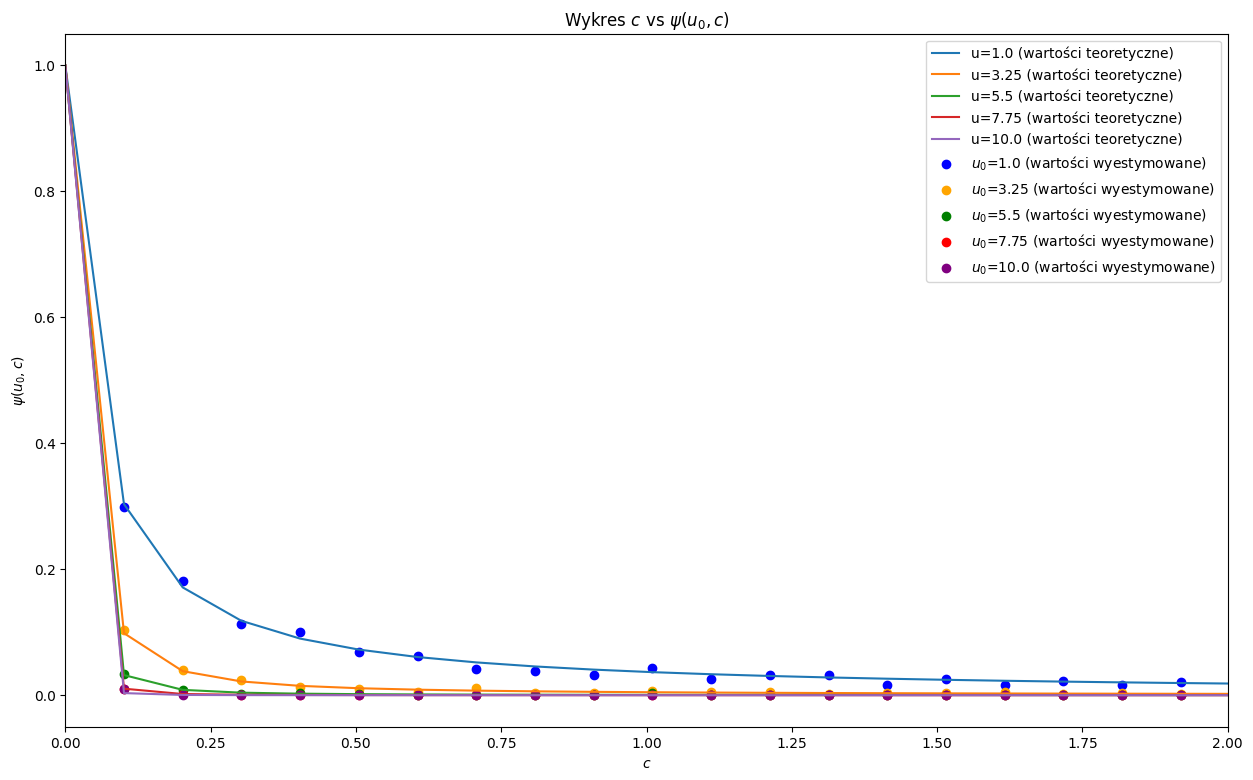

In [ ]:
us2 = np.linspace(0,10,100)
plt.figure(figsize=(15,9))
plt.plot(us2, list(zip(pcs6, pcs7, pcs8, pcs9, pcs10)), label=[f"u={u0s[0]} (wartości teoretyczne)", f"u={u0s[1]} (wartości teoretyczne)", f"u={u0s[2]} (wartości teoretyczne)", f"u={u0s[3]} (wartości teoretyczne)", f"u={u0s[4]} (wartości teoretyczne)"])
plt.scatter(us2[1::], sim6[1::], color = "blue", label= f"$u_0$={u0s[0]} (wartości wyestymowane)")
plt.scatter(us2[1::], sim7[1::], color = "orange", label = f"$u_0$={u0s[1]} (wartości wyestymowane)")
plt.scatter(us2[1::], sim8[1::], color = "green", label = f"$u_0$={u0s[2]} (wartości wyestymowane)")
plt.scatter(us2[1::], sim9[1::], color = "red", label = f"$u_0$={u0s[3]} (wartości wyestymowane)")
plt.scatter(us2[1::], sim10[1::], color = "purple", label = f"$u_0$={u0s[4]} (wartości wyestymowane)")
plt.legend(loc='best')
plt.title("Wykres $c$ vs $\psi (u_0, c)$")
plt.xlabel("$c$")
plt.ylabel("$\psi (u_0, c)$")
ax = plt.gca()
ax.set_xlim([0,2])
plt.show()

In [ ]:
def inv_ruin(u, psi, lambd, eta):
    x = u * psi * np.exp(u/eta)/eta
    w = lambertw(x).real
    return lambd * u/w

In [ ]:
psi0_min = 0.02
psi0_max = 0.1
dpsi0 = 5
psi0s = np.linspace(psi0_min, psi0_max, dpsi0)

In [ ]:
cs1,cs2,cs3,cs4,cs5 = inv_ruin(us, psi0s[0], lambd, eta), inv_ruin(us, psi0s[1], lambd, eta), inv_ruin(us, psi0s[2], lambd, eta), inv_ruin(us, psi0s[3], lambd, eta), inv_ruin(us, psi0s[4], lambd, eta)

In [ ]:
def find_all_c(T, n, u_vector, c_test, psi, lambd=1, eta=1):
    c_found = np.zeros(len(u_vector))
    
    for i, u in enumerate(u_vector):
        psi_low = psi_high = psi_test = 0
        c_low = c_test[0]
        c_high = c_test[-1]
        
        while c_high - c_low > 0.01:  # Precyzja szukania wartości c
            c_mid = (c_low + c_high) / 2
            psi_test = ruin_prob_estim(eta, u, c_mid, T, lambd, n)
            
            if psi_test > psi:
                c_low = c_mid
            else:
                c_high = c_mid
        
        c_found[i] = c_high
    
    return c_found

In [ ]:
c_test = np.linspace(1.5,10,100)
T=10
c_1_empiric = find_all_c(T,1000,us,c_test,psi0s[0])
c_2_empiric = find_all_c(T,1000,us,c_test,psi0s[1])
c_3_empiric = find_all_c(T,1000,us,c_test,psi0s[2])
c_4_empiric = find_all_c(T,1000,us,c_test,psi0s[3])
c_5_empiric = find_all_c(T,1000,us,c_test,psi0s[4])


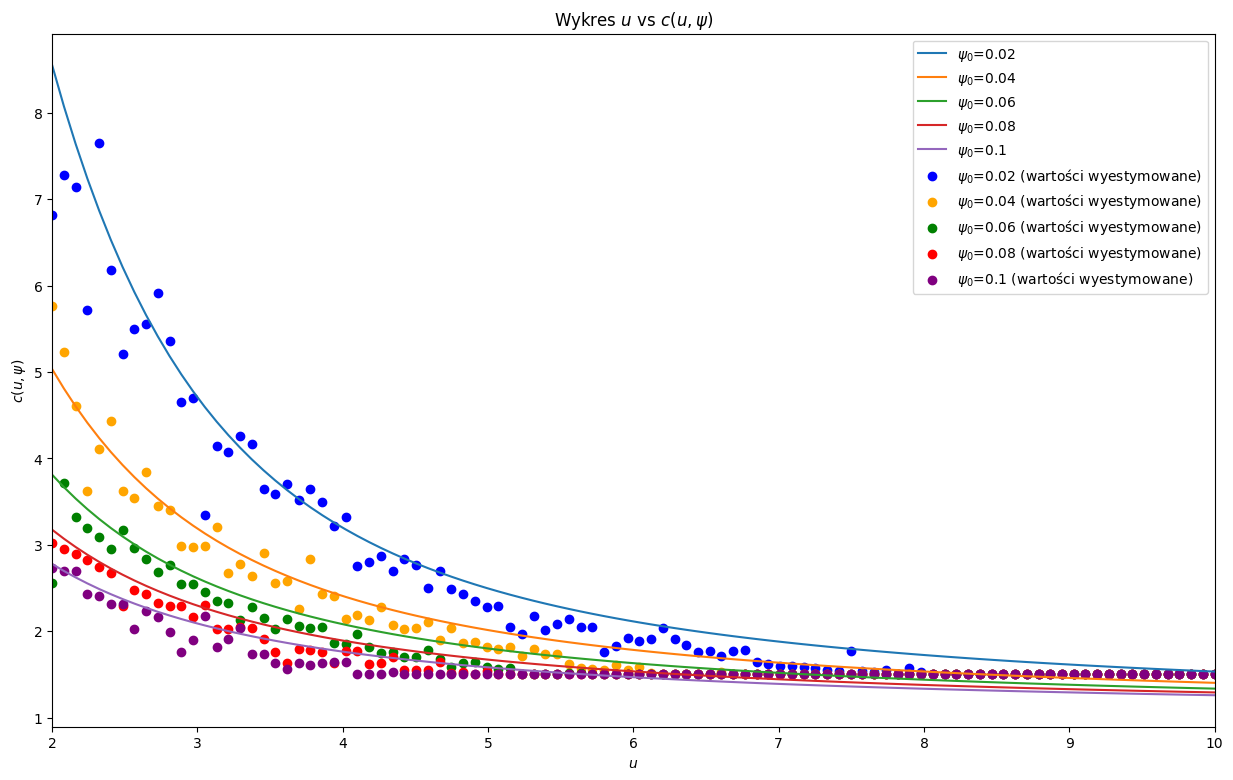

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(us, list(zip(cs1,cs2,cs3,cs4,cs5)), label=[f"$\psi_0$={psi0s[0]}", f"$\psi_0$={psi0s[1]}", f"$\psi_0$={psi0s[2]}", f"$\psi_0$={psi0s[3]}", f"$\psi_0$={psi0s[4]}"])
plt.scatter(us, c_1_empiric, color = "blue", label= f"$\psi_0$={psi0s[0]} (wartości wyestymowane)")
plt.scatter(us, c_2_empiric, color = "orange", label = f"$\psi_0$={psi0s[1]} (wartości wyestymowane)")
plt.scatter(us, c_3_empiric, color = "green", label = f"$\psi_0$={psi0s[2]} (wartości wyestymowane)")
plt.scatter(us, c_4_empiric, color = "red", label = f"$\psi_0$={psi0s[3]} (wartości wyestymowane)")
plt.scatter(us, c_5_empiric, color = "purple", label = f"$\psi_0$={psi0s[4]} (wartości wyestymowane)")
plt.legend(loc='best')
plt.title("Wykres $u$ vs $c(u, \psi)$")
plt.xlabel("$u$")
plt.ylabel("$c(u, \psi)$")
ax = plt.gca()
ax.set_xlim([2, 10])
plt.show()

# Zadanie 1 ACORN generator

In [ ]:
#generator N liczb pseudolosowych Yk i macierz X 
import numpy as np
import matplotlib.pyplot as plt

#parametry
M= 2**89-1
k=9
Lag=10**3
N=2600

#generator ACORN
def ACORN(N, k, M, Lag):
  if N<Lag:
    raise ValueError("N musi być większe lub równe Lag. Podaj poprawne argumenty.")
  
  seed= 9999999


  X = [[0]*((N+Lag+1)) for _ in range(k+1)]
  X[0][0]= seed
  for i in range(k+1):
    for j in range(1,(N+Lag+1)):
      X[i][j] = (X[i-1][j] + X[i][j-1])%M

  Yk = [X[k][j]/M for j in range(1,(N+Lag+1))]
  return Yk[Lag::], X

Yk_result, X_matrix = ACORN(N, k, M, Lag)
n=np.random.rand(2600) 

print("Macierz X:")
for row in X_matrix:
    print(row)
print("N liczb pseudolosowych Yk:")
print(Yk_result)
print(len(Yk_result))
print(np.mean(Yk_result))

 42495745750425, 44212745578725, 45981255401874, 47802295219770, 49676895032310, 51606094839390, 53590944640905, 55632504436749, 57731844226815, 59890044010995, 62108193789180, 64387393561260, 66728753327124, 69133393086660, 71602442839755, 74137042586295, 76738342326165, 79407502059249, 82145691785430, 84954091504590, 87833891216610, 90786290921370, 93812500618749, 96913740308625, 100091239990875, 103346239665375, 106679989332000, 110093748990624, 113588788641120, 117166388283360, 120827837917215, 124574437542555, 128407497159249, 132328336767165, 136338286366170, 140438685956130, 144630885536910, 148916245108374, 153296134670385, 157771934222805, 162345033765495, 167016833298315, 171788742821124, 176662182333780, 181638581836140, 186719381328060, 191906030809395, 197199990279999, 202602729739725, 208115729188425, 213740478625950, 219478478052150, 225331237466874, 231300276869970, 237387126261285, 243593325640665, 249920425007955, 256369984362999, 262943573705640, 269642773035720, 276

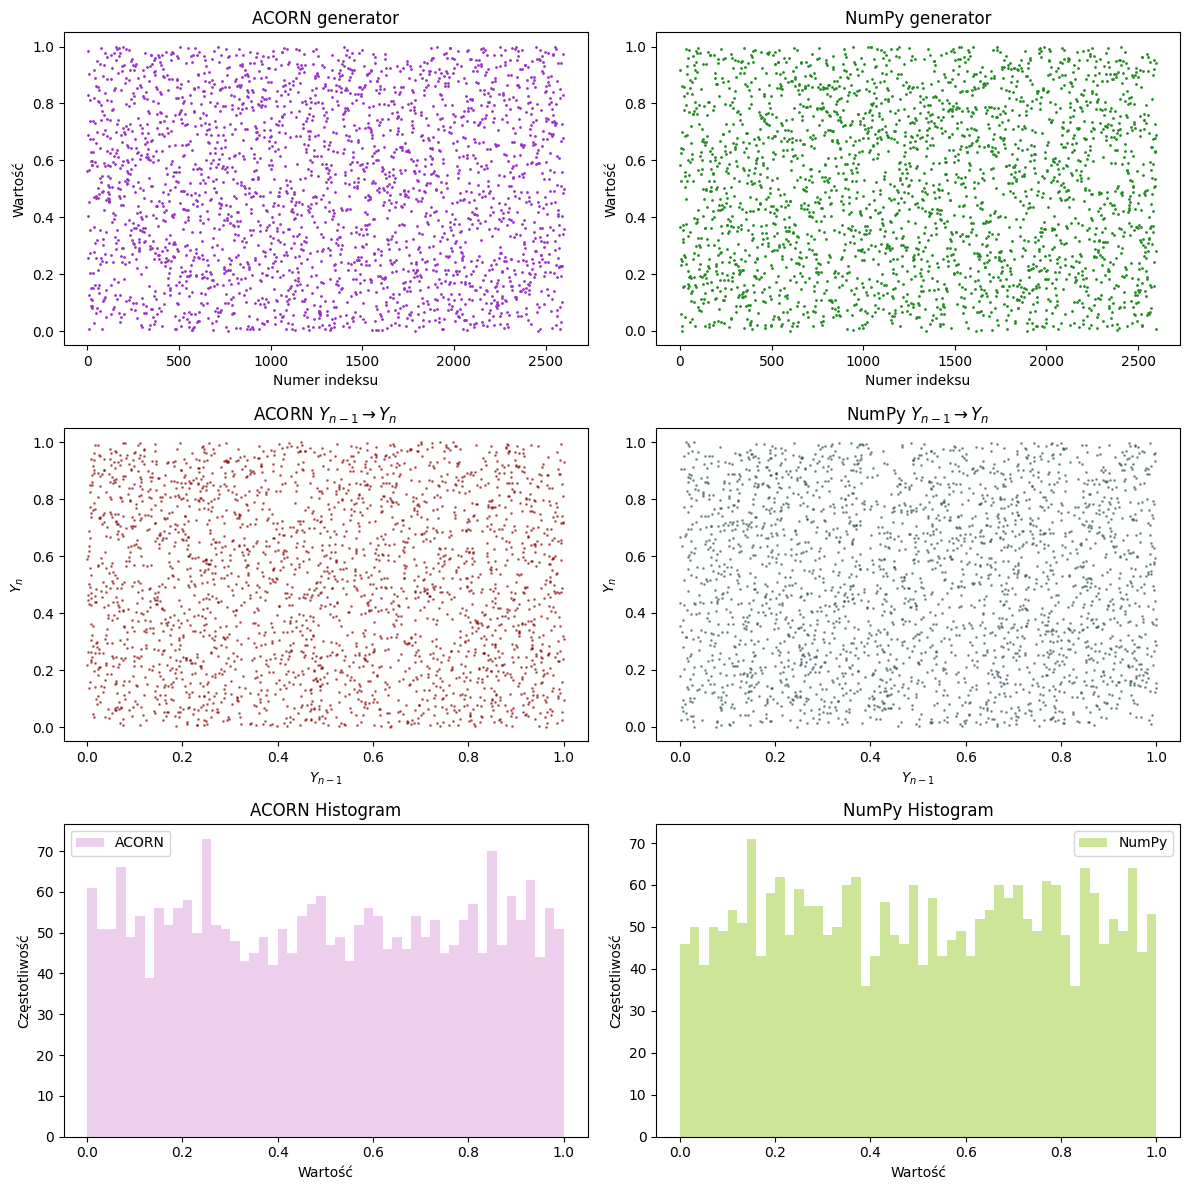

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 12))

# ACORN generator N liczb pseudolosowych Yk
plt.subplot(3, 2, 1)
plt.plot(Yk_result, 'o', color='darkorchid', markersize=1)
plt.title('ACORN generator')
plt.xlabel('Numer indeksu')
plt.ylabel('Wartość')

# ACORN $Y_{n-1} \rightarrow Y_n$
plt.subplot(3, 2, 3)
plt.scatter(Yk_result[:-1], Yk_result[1:], alpha=0.5, s=1, color='darkred')
plt.title('ACORN $Y_{n-1} \\rightarrow Y_n$')
plt.xlabel('$Y_{n-1}$')
plt.ylabel('$Y_n$')

# ACORN tworzenie histogramu
plt.subplot(3, 2, 5)
plt.hist(Yk_result, bins=50, alpha=0.5, label='ACORN', color='plum')
plt.title('ACORN Histogram')
plt.xlabel('Wartość')
plt.ylabel('Częstotliwość')
plt.legend()

# NumPy generator N liczb 
plt.subplot(3, 2, 2)
plt.plot(n, 'o', color='forestgreen', markersize=1)
plt.title('NumPy generator')
plt.xlabel('Numer indeksu')
plt.ylabel('Wartość')

# NumPy $Y_{n-1} \rightarrow Y_n$
plt.subplot(3, 2, 4)
plt.scatter(n[:-1], n[1:], alpha=0.5, s=1, color='darkslategray')
plt.title('NumPy $Y_{n-1} \\rightarrow Y_n$')
plt.xlabel('$Y_{n-1}$')
plt.ylabel('$Y_n$')

# NumPy tworzenie histogramu
plt.subplot(3, 2, 6)
plt.hist(n, bins=50, alpha=0.5, label='NumPy', color='yellowgreen')
plt.title('NumPy Histogram')
plt.xlabel('Wartość')
plt.ylabel('Częstotliwość')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Mierzenie czasu działania obu generatorów, prównanie wydajności
import timeit

#uruchamiam funkcje przykładowo 20 razy i licze średni czas wykonania pojedyńczej funkcji 
def czas_ACORN():
    ACORN(N, k, M, Lag)
 
czas_trwania_ACORN=timeit.timeit(czas_ACORN, number=20)/20

def czas_NumPy():
    np.random.random(N)

czas_trwania_NumPy=timeit.timeit(czas_NumPy, number=20)/20

# Wyświetlanie czasów wykonania naszych funkcji
print(f"Czas wykonania funkcji ACORN: {czas_trwania_ACORN:.8f} sekundy")
print(f"Czas wykonania funkcji NumPy: {czas_trwania_NumPy:.8f} sekundy")

# Porównywanie czasów wykonania 
if czas_trwania_ACORN > czas_trwania_NumPy:
    print("Funkcja ACORN działa dłużej niż funkcja NumPy, więc generator NumPy jest bardziej wydajny")
elif czas_trwania_ACORN < czas_trwania_NumPy:
    print("Funkcja NumPy działa dłużej niż funkcja ACORN, więc generator ACORN jest bardziej wydajny")
else:
    print("Obie funkcje działają równie długo.")

Czas wykonania funkcji ACORN: 0.01321231 sekundy
Czas wykonania funkcji NumPy: 0.00002329 sekundy
Funkcja ACORN działa dłużej niż funkcja NumPy, więc generator NumPy jest bardziej wydajny


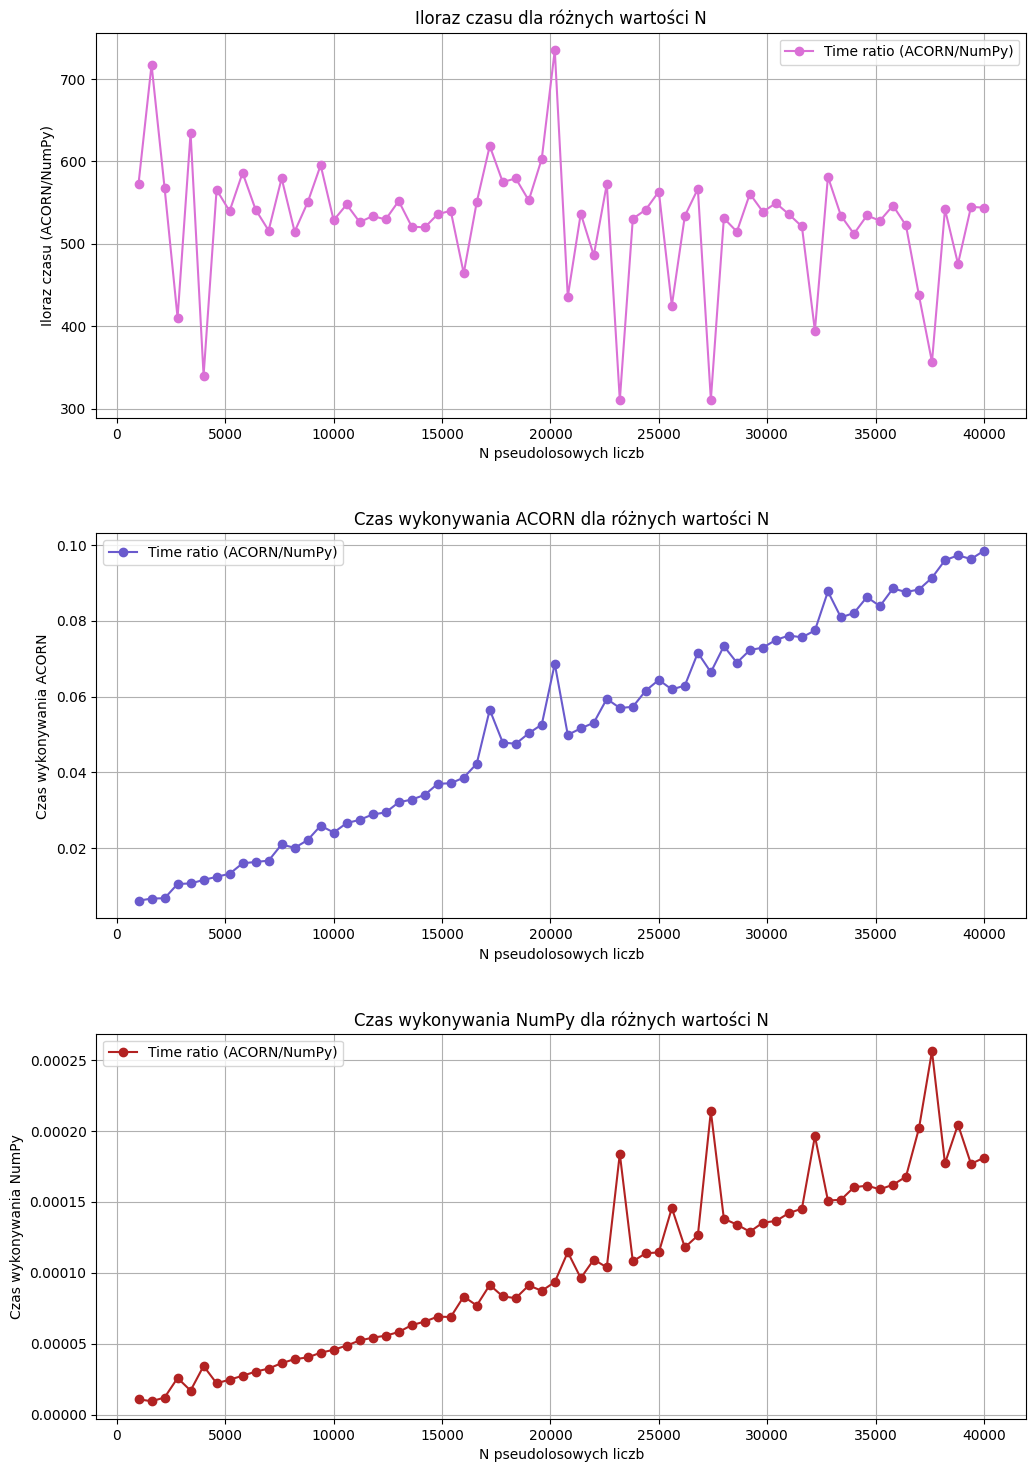

In [ ]:
#Sprawdzenie wydajności w zależności od różnych wartośći N naszych generowanych liczb pseudolosowych

#Tworzenie zależności na podstawie ilorazu czasów działania obu generatorów oraz osobne wykresy dla czasów pojedyńczych generatorów

iloraz_czasu= czas_trwania_ACORN/czas_trwania_NumPy

#wartości N dla których zbadamy iloraz 
N2= range(1000, 40001,600)

#listy dla przechowania wyników czasów
ACORN_czasy=[]
NumPy_czasy=[]
ilorazy=[]

for N in N2:
    def czas_ACORN():
        ACORN(N, k, M, Lag)
    czas_trwania_ACORN=timeit.timeit(czas_ACORN, number=20)/20
    ACORN_czasy.append(czas_trwania_ACORN)

    def czas_NumPy():
        np.random.random(N)

    czas_trwania_NumPy=timeit.timeit(czas_NumPy, number=20)/20
    NumPy_czasy.append(czas_trwania_NumPy)

    iloraz_czasu= czas_trwania_ACORN/czas_trwania_NumPy
    ilorazy.append(iloraz_czasu)


plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
plt.plot(N2, ilorazy, 'o-', label='Time ratio (ACORN/NumPy)', color='orchid')
plt.xlabel('N pseudolosowych liczb')
plt.ylabel('Iloraz czasu (ACORN/NumPy)')
plt.title('Iloraz czasu dla różnych wartości N')
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 2)
plt.plot(N2, ACORN_czasy, 'o-', label='Time ratio (ACORN/NumPy)', color='slateblue')
plt.xlabel('N pseudolosowych liczb')
plt.ylabel('Czas wykonywania ACORN')
plt.title('Czas wykonywania ACORN dla różnych wartości N')
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 3)
plt.plot(N2, NumPy_czasy, 'o-', label='Time ratio (ACORN/NumPy)', color='firebrick')
plt.xlabel('N pseudolosowych liczb')
plt.ylabel('Czas wykonywania NumPy')
plt.title('Czas wykonywania NumPy dla różnych wartości N')
plt.legend()
plt.grid(True)

plt.subplots_adjust(hspace=0.3)

# 4. WARUNKOWA WARTOŚC OCZEKIWANA

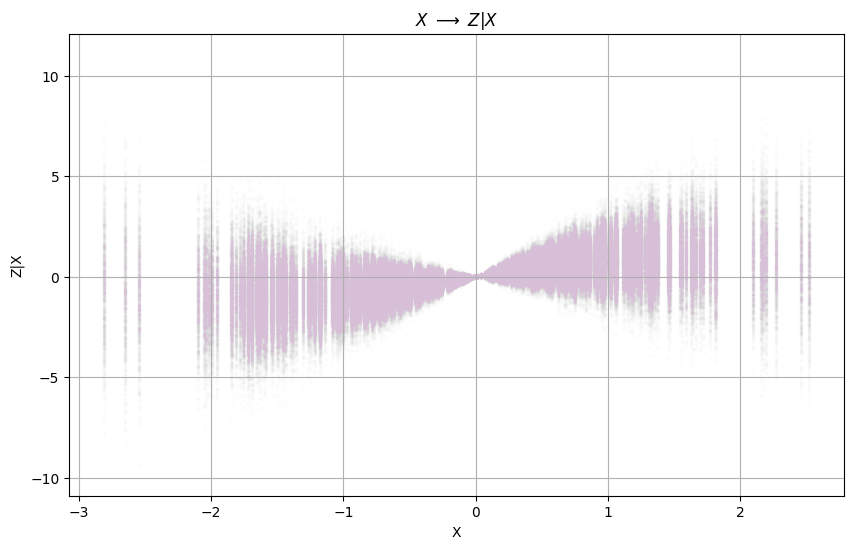

In [ ]:
#a
import numpy as np
import matplotlib.pyplot as plt

# liczba próbek n zmiennej X i Y oraz liczba powtórzeń n2 dla której wygenerujemy Z|X
n = 400
n2 = 1000

# generowanie n próbek z rozkładu N(0,1)
X = np.random.normal(0, 1, n)

Z_pod_warunkiem_X = np.zeros((n, n2))  # Tablica do przechowywania Z|X

for i in range(n):
    x_i = X[i]
    Y = np.random.normal(0, 1, n2)  # Generowanie n2 próbek Y

    Z_i = x_i * Y + np.sin(x_i)  # Z = XY + sin(X)

    Z_pod_warunkiem_X[i, :] = Z_i  # Zapisanie wyników do tablicy

# Tworzenie wykresu scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(np.repeat(X, n2), Z_pod_warunkiem_X.flatten(), alpha=0.01, color='thistle',s=3)
plt.xlabel('X')
plt.ylabel('Z|X')
plt.title('$X$ $\\longrightarrow$ $Z|X$')
plt.grid(True)
plt.show()

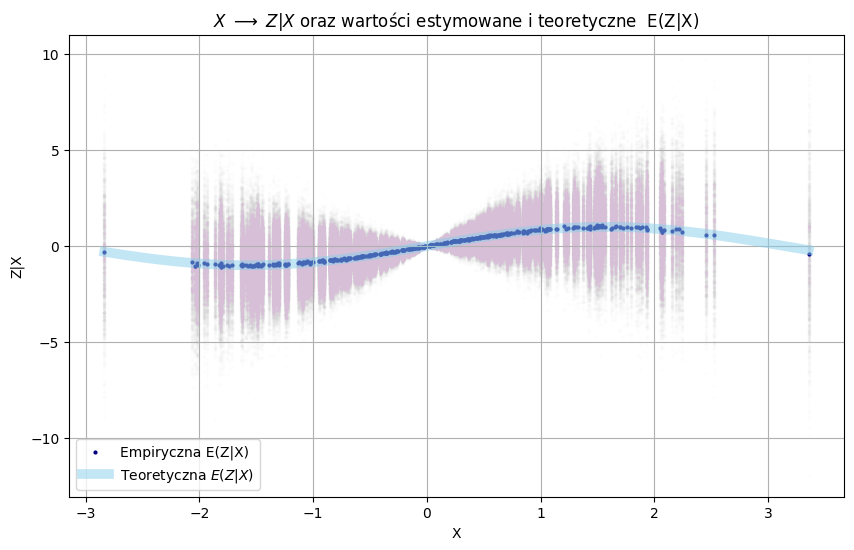

In [ ]:
expected_values_x = X  
expected_values_y = np.mean(Z_pod_warunkiem_X, axis=1)  # Obliczenie średniej dla każdego X_i

x_min, x_max = np.min(X), np.max(X)
x_range = np.linspace(x_min, x_max, n)

# Tworzenie wykresu scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(np.repeat(X, n2), Z_pod_warunkiem_X.flatten(), alpha=0.01, color='thistle', s=3)
plt.xlabel('X')
plt.ylabel('Z|X')
plt.title('$X$ $\\longrightarrow$ $Z|X$ oraz wartości estymowane i teoretyczne  E(Z|X)')

# Dodanie wartości empiryczne, estymowane E(Z|X)
plt.scatter(expected_values_x, expected_values_y, c='navy', label="Empiryczna E(Z|X)", s=4)

#Dodatnie wartości teoretyczne E(Z|X)
plt.plot(x_range, np.sin(x_range), '-', linewidth=7, c='skyblue', label="Teoretyczna $E(Z|X)$", alpha=0.5)

plt.legend()
plt.grid(True)
plt.show()

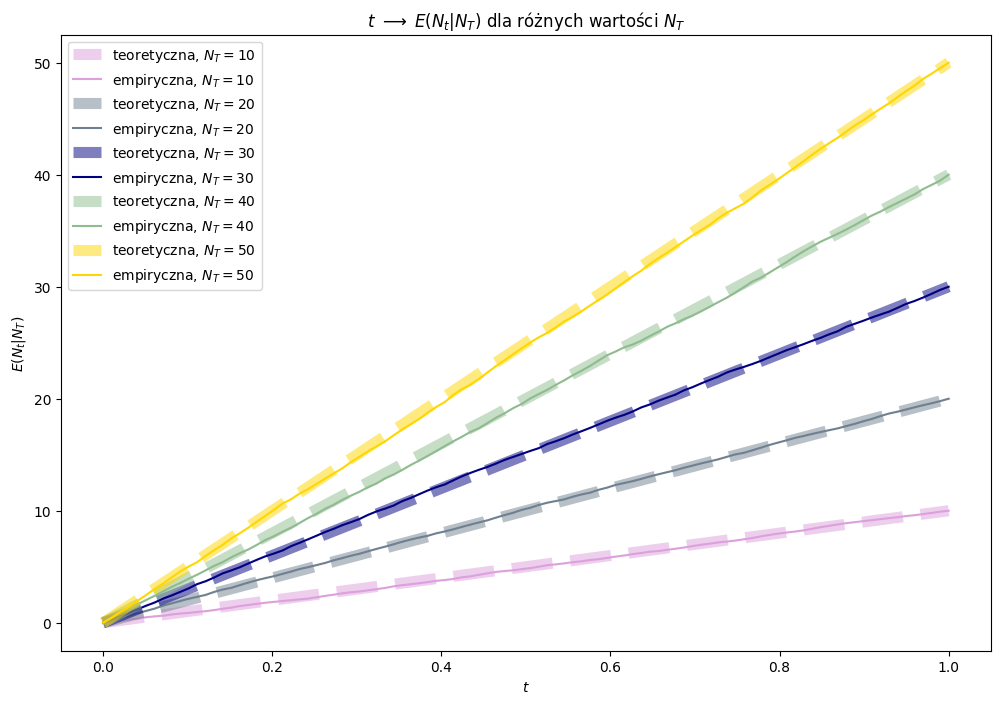

In [ ]:
#b
import numpy as np
import matplotlib.pyplot as plt

# Parametry symulacji
T = 1  
monte_carlo = 200
kroki_czasowe = 100
ts = np.linspace(0, T, kroki_czasowe)

def proces_Poissona(T, z):
    T_prime = np.random.uniform(0, T, z)
    T_prime.sort()
    return T_prime

def generowanie_liczby_klientów_w_sklepie(T, N_T, monte_carlo, kroki_czasowe, ts):

    liczba_klientów_w_sklepie = np.zeros((monte_carlo, kroki_czasowe))

    for i in range(monte_carlo):
        N_t = proces_Poissona(T, N_T)

        łączna_liczba_klientów = 0
        aktualnie_sprawdzane_N_t = 0

        for t_index, t in enumerate(ts):
            while (
                aktualnie_sprawdzane_N_t < len(N_t) and N_t[aktualnie_sprawdzane_N_t] <= t
            ):
                łączna_liczba_klientów += 1
                aktualnie_sprawdzane_N_t += 1
            liczba_klientów_w_sklepie[i, t_index] = łączna_liczba_klientów
    
    return liczba_klientów_w_sklepie

def generowanie_oczekiwanej_wartości_klientów(liczba_klientów_w_sklepie):
    oczekiwane_wartości_x = ts
    oczekiwane_wartości_y = np.mean(liczba_klientów_w_sklepie, axis=0)
    
    return oczekiwane_wartości_x, oczekiwane_wartości_y

# Symulacja dla różnych N_T
N_Ts = [10, 20, 30, 40, 50]
kolory = ['plum', 'slategray', 'navy', "darkseagreen", "gold"]

plt.figure(figsize=(12, 8))

for N_T, color in zip(N_Ts, kolory):
    liczba_klientów_w_sklepie = generowanie_liczby_klientów_w_sklepie(T, N_T, monte_carlo, kroki_czasowe, ts)
    estymowane_wartości_x, estymowane_wartości_y = generowanie_oczekiwanej_wartości_klientów(liczba_klientów_w_sklepie)

    plt.plot(ts, (ts * N_T) / T, '--', linewidth=8, color=color, alpha=0.5, label=f"teoretyczna, $N_T = {N_T}$")
    plt.plot(estymowane_wartości_x, estymowane_wartości_y, label=f"empiryczna, $N_T = {N_T}$", color=color)
    plt.scatter(ts, estymowane_wartości_y, color=color, s=2, alpha=0.03, marker='o')

plt.title('$t$ $\\longrightarrow$ $E(N_t|N_T)$ dla różnych wartości $N_T$')
plt.xlabel('$t$')
plt.ylabel('$E(N_t|N_T)$')

plt.legend()
plt.show()





# 3.  METODY REDUKCJI WARIANCJI

W zadaniu trzecim mamy za zadanie porównać wyniki szacowania liczby π za pomocą klasycznej metody Monte Carlo z wynikami uzyskanymi przy użyciu metod Monte Carlo z zastosowaniem dwóch technik redukcji wariancji. Pierwszą z nich będzie metoda zmiennej kontrolnej, drugą metoda odbić lustrzanych. Wobec tego zaczniemy najpierw od zaimplementowania metody Monte Carlo i metod redukcji wariancji.

In [ ]:
def monte_carlo(func, x_lim, y_lim, n):

    '''
    Zwraca przybliżoną wartość pola pod wykresem (całki) funkcji func na przedziale od 0 do x_lim, 
    policzonej przy pomocy metody Monte Carlo.

    Na początku tworzona jest zmienna count zliczająca punkty, które trafiły pod wykres funkcji func.

    Następnie n razy generowane są dwie zmienne X i Y z rozkładu jednostajnego od 0 do odpowiednio x_lim i y_lim.

    Jeżeli wartość funkcji func w wygenerowanym punkcie X jest większa lub równa Y, to punkt o współrzędnych (X,Y)
    znajduje się pod wykresem tej funkcji.

    Wtedy też do zmiennej count dodawane jest jeden.

    Na koniec zwracany jest wynik.

            Parametry:
                    func (function): Funkcja, której pole pod wykresem chcemy przybliżyć
                    x_lim (int/float): Górna granica całkowania, maksymalna wartość współrzędnej X
                    y_lim (int/float): Maksimum funkcji func na predziale od 0 do x_lim, maksymalna wartość 
                                       współrzędnej Y
                    n (int): Ilość wysmulowanych próbek

            Zwrot:
                    x_lim*y_lim*count/n (float): Iloczyn pola prostokątu, w którym zawiera się funkcja func,
                                                 ze stosunkiem punktów, które trafiły pod wykres funkjci func, do
                                                 liczby wszystkich wygenerowanych punktów
    '''

    count = 0
    for i in range(int(n)):
        X = np.random.uniform(0,x_lim)
        Y = np.random.uniform(0,y_lim)
        if func(X) >= Y:
            count += 1
    return(x_lim*y_lim*count/n)

In [ ]:
def control_variates(func1, func2, e, n):

    '''
    Zwraca przybliżoną wartość całki funkcji func1 na przedziale od 0 do 1.
    
    Obliczana jest ona przy pomocy metody Monte Carlo z wykorzystaniem zmiennej kontrolnej.

    Na początku funkcja losuje 100*n próbek, aby obliczyć współczynnik c.

    Następnie losuje nowe próbki do głównej estymacji i wykorzystuje wzór ze zmienną kontrolną.
    
    Końcowo zwraca obliczoną według wzoru ostateczną estymację wartości całki.

    Parametry:
        func1 (function): Funkcja, której całkę liczymy
        func2 (function): Funkcja kontrolna, dla której wartość całki jest znana
        e (float): Wartość całki funkcji func2 na przedziale [0, 1]
        n (int): Liczba próbek używanych w estymacji

    Zwrot:
        f2 - c * (g2 - e) (float): Estymowana wartość całki funkcji func1 na przedziale [0, 1]
    '''

    U1 = np.random.uniform(0, 1, 100*int(n))
    f1 = func1(U1)
    g1 = func2(U1)

    c = -np.cov(f1, g1, ddof=1)[0, 1]/np.var(g1)

    U2 = np.random.uniform(0, 1, int(n))
    f2 = np.mean(func1(U2))
    g2 = np.mean(func2(U2))

    return f2 - c * (g2 - e)

In [ ]:
def antithetic_variates(func, x_lim, y_lim, n):

    '''
    Zwraca przybliżoną wartość pola pod wykresem (całki) funkcji func na przedziale od 0 do x_lim.

    Wykorzystana jest do tego metoda Monte Carlo z metodą odbić lustrzanych, redukująca wariancję.

    Na początku tworzona jest zmienna count zliczająca punkty, które trafiły pod wykres funkcji func.

    Następnie n razy generowana jest zmienna X z rozkładu jednostajnego od 0 do x_lim.
    
    Na podstawie tej zmiennej obliczane jest X_anti = x_lim - X.

    Generowana jest również zmienna Y z rozkładu jednostajnego od 0 do y_lim.

    W kolejnym kroku sprawdzane jest położenie punktów (X,Y) i (X_anti,Y), względem wykresu funkcji func.

    Następnie do zmiennej count dodawane jest jeden dla każdego z tych punktów, który trafił pod wykres funkcji.

    Na koniec zwracany jest wynik, liczony jak w kalsycznej metodzie Monte Carlo, ale podzielony przez 2 (2 punkty w każdym kroku).

            Parametry:
                    func (function): Funkcja, której pole pod wykresem chcemy przybliżyć
                    x_lim (int/float): Górna granica całkowania, maksymalna wartość współrzędnej X
                    y_lim (int/float): Maksimum funkcji func na predziale od 0 do x_lim, maksymalna wartość 
                                       współrzędnej Y
                    n (int): Ilość wysmulowanych próbek

            Zwrot:
                    x_lim*y_lim*count/(2*n) (float): Iloczyn pola prostokątu, w którym zawiera się funkcja func,
                                                     ze stosunkiem punktów, które trafiły pod wykres funkcji func, do
                                                     liczby wszystkich wygenerowanych punktów (uwzględniając X i x_lim-X)
    '''

    count = 0
    for i in range(int(n)):
        X = np.random.uniform(0,x_lim)
        X_anti = x_lim-X
        Y = np.random.uniform(0,y_lim)
        if func(X) >= Y:
            count += 1
        if func(X_anti) >= Y:
            count += 1
    return(x_lim*y_lim*count/(2*n))

W tym momencie możemy sprawdzić jak każdy ze stworzonych algorytmów radzi sobie z szacowaniem danej nam całki.

In [ ]:
N = np.linspace(1000, 10000, 10)
errorsMC = [] #średni błąd czystego Monte Carlo
errorsCV = [] #średni błąd Monte Carlo z metodą zmiennej kontrolnej
errorsAV = [] #średni błąd Monte Carlo z metodą odbić lustrzanych
resultsMC = [] #wyniki pojedynczych symulacji czystego Monte Carlo dla n>5000
resultsCV = [] #wyniki pojedynczych symulacji Monte Carlo z metodą zmiennej kontrolnej dla n>5000
resultsAV = [] #wyniki pojedynczych symulacji  Monte Carlo z metodą odbić lustrzanych dla n>5000
integral = lambda x: 4/(1+x**2)
den = lambda x: 1+x**2
e = 4/3
x_max = 1
y_max = 4
k = 1000

for n in N:
    MC = 0
    CV = 0
    AV = 0
    for j in range(k):
        resultMC = monte_carlo(integral, x_max, y_max, n)
        resultCV = control_variates(integral, den, e, n)
        resultAV = antithetic_variates(integral, x_max, y_max, n)
        MC += abs(np.pi-resultMC)
        CV += abs(np.pi-resultCV)
        AV += abs(np.pi-resultAV)
        if int(n) > 5000:
            resultsMC.append(resultMC)
            resultsCV.append(resultCV)
            resultsAV.append(resultAV)
    errorsMC.append(MC/k)
    errorsCV.append(CV/k)
    errorsAV.append(AV/k)

print("Błąd czystego Monte Carlo:", np.mean(errorsMC))
print("Błąd Monte Carlo z metodą zmiennej kontrolnej:", np.mean(errorsCV))
print("Błąd Monte Carlo z metodą odbić lustrzanych:", np.mean(errorsAV))

plt.scatter(N,errorsMC, label = "Pure MC")
plt.scatter(N,errorsCV, label = "Control variates")
plt.scatter(N,errorsAV, label = "Antithetic variates")
plt.legend(loc = "best")
plt.title("Średni błąd pomiarowy")
plt.xlabel("Długość próbki")
plt.ylabel("Wielkość błędu")
plt.show()

plt.hist(resultsMC, label = "Pure MC", alpha = 0.3, bins = 50, density = True)
plt.hist(resultsCV, label = "Control variates", alpha = 0.3, bins = 50, density = True)
plt.hist(resultsAV, label = "Antithetic variates", alpha = 0.3, bins = 50, density = True)
plt.legend(loc = "best")
plt.title("Histogram wyników symulacji każdej z metod")
plt.axvline(x=np.pi, color='r', linestyle='--', linewidth=2, label='Wartość teoretyczna liczby pi')
plt.show()

fig, ax = plt.subplots()
boxplot_data = [resultsMC, resultsCV, resultsAV]
ax.boxplot(boxplot_data)
ax.set_xticklabels(["Pure MC", "Control variates", "Antithetic variates"])
ax.axhline(y=np.pi, color='r', linestyle='--', linewidth=2, label='Wartość teoretyczna liczby pi')
plt.legend(loc = "best")
plt.title("Wykresy pudełkowe wyników symulacji każdej z metod")
plt.show()

<class 'int'>


NameError: name 'monte_carlo' is not defined

Jak widać zarówno po samych wartościach średniego błędu każdej symulacji, jak i po wykresach punktowym, histogramie i pudełkowych, metody redukcji wariancji wydatnie pomagają nam się zbliżyć do wartości teoretycznej liczby pi, względem czystej metody Monte Carlo. Tak naprawdę skuteczność metody zmiennej kontrolnej, jak i metody odbić lustrzanych, są bardzo do siebie zbliżone i ciężko stwierdzić, która z tych dwóch jest lepsza. Szczególnie dobrze widać zmniejszenie się wariancji na wykresie pudełkowym, gdzie dla metod redukcji wariancji wykresy rozciągają się na mniejszej rozpiętości na osi OY niż wykres dla oryginalnego Monte Carlo. Ponadto na histogramie wyników widać jak Monte Carlo, bez metod redukcji wariancji,  daje wiele estymacji znajdujących się daleko od wartości rzeczywistej liczby pi - niebieski histogram blisko rzeczywistej wartości jest niższy, niż pozostałe dwa, a im dalej od rzeczywistej wartości zaczyna się wybijać nad pozostałe dwa. Zwykły wykres punktowy z kolei pokazuje jak wraz ze wzrostem liczby próbek n, maleje błąd każdego z algorytmów, ale także utrzymującą się przewagę metod redukcji wariancji nad czystym Monte Carlo.

# 6.  PRAWA ARCUSA SINUSA

W tym zadaniu mamy symulacyjnie sprawdzić prawdziwość praw arcusa sinusa dla procesu Wienera. Zaczniemy wobec tego od implementacji samego procesu Wienera, inspirując się implementacją n-wymiarowego ruchu Browna, przedstawioną na naszych zajęciach.

In [ ]:
def wiener_process(dt,T):

    '''
    Generuje trajektorię procesu Wienera dla zadanych parametrów czasu i kroku czasowego.

    Na początku tworzony jest wektor czasu, który jest równomiernie podzielony na odcinki o długości dt, od 0 do T. 
    
    Następnie inicjalizowana jest lista X, która będzie przechowywać kolejne położenia cząstki.

    Zawiera ona od razu 0, ponieważ proces Wienera rozpoczyna się w zerze.

    W pętli, dla każdego kroku czasowego, generowana jest zmienna losowa z rozkładu normalnego o średniej 0
    i wariancji dt, która reprezentuje zmianę położenia cząstki w tym kroku.

    Dodawana jest ona do ostatniego, w tym momencie, elementu listy, a wynik tej sumy dodawany jest do listy X.

    Na koniec zwracana jest lista wynikowa X.

            Parametry:
                    dt (float): Krok czasowy
                    T (float): Całkowity czas symulacji

            Zwrot:
                    X (list): Lista zawierająca położenia cząstki w kolejnych krokach czasowych
    '''

    Time = np.linspace(0,T,int(np.ceil(T/dt)))
    l = len(Time)
    X = [0]

    for i in range(1,l):
        X.append(X[-1]+np.random.normal(0,dt))

    return(X)

Następnie stworzymy potrzebne nam zmienne, takie jak funkcje teoretyczne gęstości i dystrybuanty rozkładu arcusa sinusa czy liczba n, oznaczająca ile razy będziemy symulować proces Wienera.

In [ ]:
n = 10000
x_list = np.linspace(0, 1, 10000)
gestosc = lambda x: 1/(np.pi*np.sqrt(x*(1-x)))
dystrybuanta = lambda x: (2/np.pi)*np.arcsin(np.sqrt(x))

W tym momencie jesteśmy w stanie zacząć weryfikowanie prawdziwości poszczególnych praw arcusa sinusa dla procesu Wienera. Pierwsze z nich twierdzi, że czas spędzony powyżej osi OX, na odcinku [0,1], przez proces Wienera ma rozkład arcusa sinusa.

/tmp/ipykernel_34/2193776347.py:4: RuntimeWarning: divide by zero encountered in divide
  gestosc = lambda x: 1/(np.pi*np.sqrt(x*(1-x)))


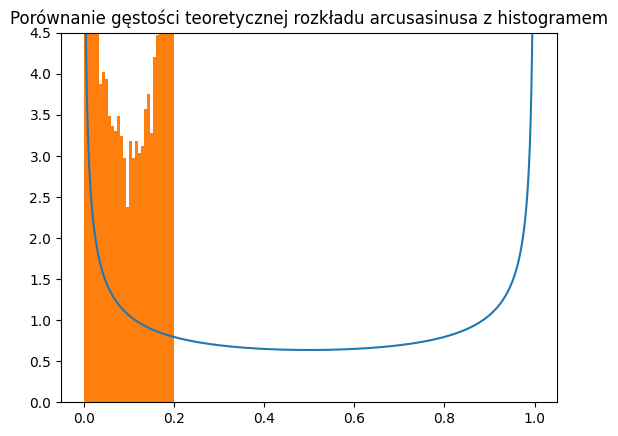

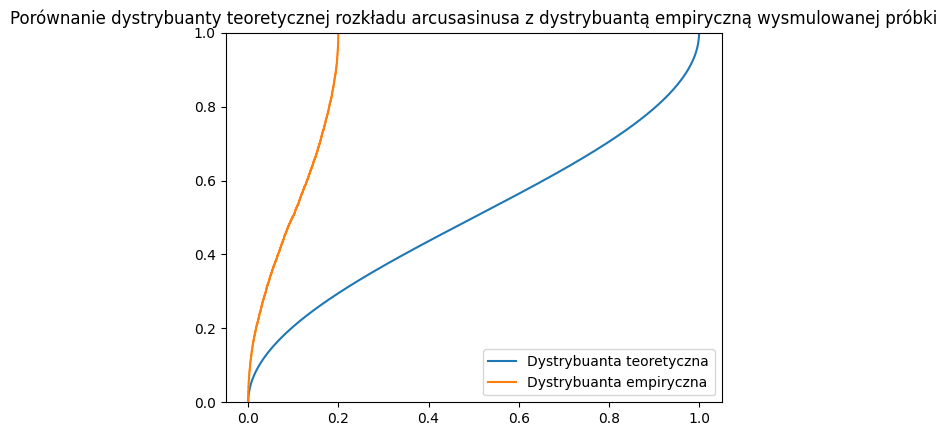

In [ ]:
time = []

for i in range(n):
    sample = wiener_process(1/n, 1)
    count = 0 #zmienna zliczająca ile kroków proces Wienera spędził powyżej 0
    for j in sample:
        if j > 0:
            count += 1
    time.append(count/n)

plt.plot(x_list, gestosc(x_list), label = "Gęstość teoretyczna")
plt.hist(time, bins = 50, density = True,  label = "Histogram wyników symulacji")
plt.title("Porównanie gęstości teoretycznej rozkładu arcusasinusa z histogramem wysmulowanej próbki")
plt.ylim(0, 4)
plt.legend(loc="best")
plt.show()

plt.plot(x_list, dystrybuanta(x_list), label = "Dystrybuanta teoretyczna")
sns.ecdfplot(time, label = "Dystrybuanta empiryczna")
plt.title("Porównanie dystrybuanty teoretycznej rozkładu arcusasinusa z dystrybuantą empiryczną wysmulowanej próbki")
plt.legend(loc="best")
plt.ylabel("")
plt.show()

Jak widać zarówno porównane gęstość i histogram, a także dystrybuanty teoretyczna i empiryczna, przyjmują bardzo podobne kształty. Na tej podstawie możemy z dużą dozą pewności stwierdzić, że badana zmienna losowa ma rozkład arcus sinusa. Teraz sprawdzimy drugie prawo arcusa sinusa mówiące, że ostatni moment uderzenia procesu Wienera w oś OX na odcinku [0,1] ma rozkład arcusa sinusa.

/tmp/ipykernel_34/1796924362.py:4: RuntimeWarning: divide by zero encountered in divide
  gestosc = lambda x: 1/(np.pi*np.sqrt(x*(1-x)))


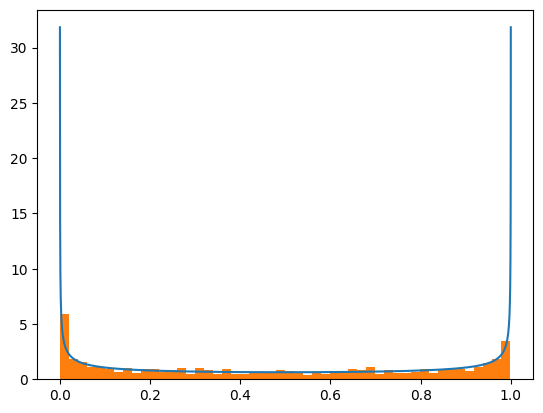

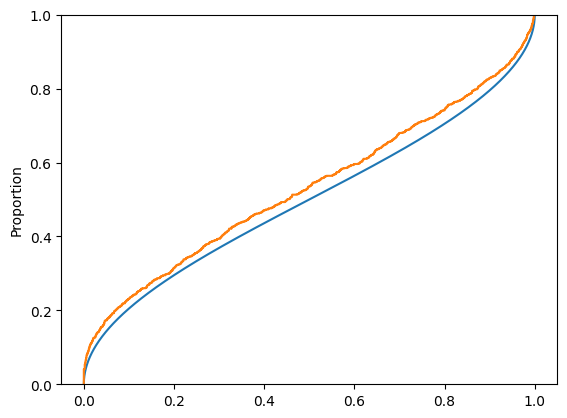

In [ ]:
last = []

for i in range(n):
    sample = wiener_process(1/n, 1)
    hit = 0
    
    for j in range(1, len(sample)):
        if sample[j-1]*sample[j] < 0:
            hit = j/n #zmienna równa ostatniemu momentowi uderzenia procesu Wienera w oś OX
    last.append(hit)

plt.plot(x_list, gestosc(x_list), label = "Gęstość teoretyczna")
plt.hist(last, bins = 50, density = True,  label = "Histogram wyników symulacji")
plt.ylim(0, 4)
plt.legend(loc="best")
plt.show()

plt.plot(x_list, dystrybuanta(x_list), label = "Dystrybuanta teoretyczna")
sns.ecdfplot(last, label = "Dystrybuanta empiryczna")
plt.title("Porównanie dystrybuanty teoretycznej rozkładu arcusasinusa z dystrybuantą empiryczną wysmulowanej próbki")
plt.legend(loc="best")
plt.ylabel("")
plt.show()

Tutaj, podobnie jak w przypadku pierwszego z praw, wykresy udowadniają, że ta zmienna również ma rozkład arcusa sinusa. Wobec tego przyszedł czas na ostatnie, trzecie, prawo stanowiące, że moment osiągnięcia maksymalnej wartości przez proces Wienera na odcinku [0,1] przyjmuje rozkład arcus sinusa.

/tmp/ipykernel_34/1796924362.py:4: RuntimeWarning: divide by zero encountered in divide
  gestosc = lambda x: 1/(np.pi*np.sqrt(x*(1-x)))


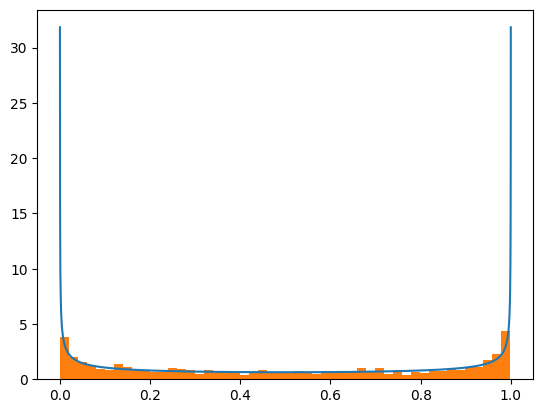

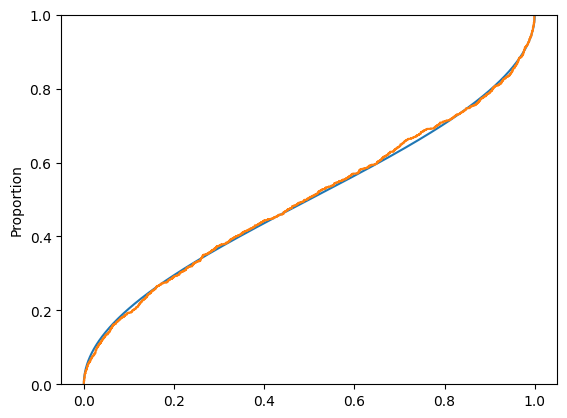

In [ ]:
maximum = []

for i in range(n):
    sample = wiener_process(1/n, 1)
    maximum.append(sample.index(max(sample))/n) #zmienna równa momentowi osiągniecia maksymalnej wartości przez proces Wienera

plt.plot(x_list, gestosc(x_list), label = "Gęstość teoretyczna")
plt.hist(maximum, bins = 50, density = True,  label = "Histogram wyników symulacji")
plt.ylim(0, 4)
plt.legend(loc="best")
plt.show()

plt.plot(x_list, dystrybuanta(x_list), label = "Dystrybuanta teoretyczna")
sns.ecdfplot(maximum, label = "Dystrybuanta empiryczna")
plt.title("Porównanie dystrybuanty teoretycznej rozkładu arcusasinusa z dystrybuantą empiryczną wysmulowanej próbki")
plt.legend(loc="best")
plt.ylabel("")
plt.show()

Spodziewanie, porównanie histogramu próbki i gęstości teoretycznej oraz dystrybuanty teoretycznej i empirycznej pozwala nam stwierdzić, że również trzecie prawo arcus sinusa dla procesu Wienera jest prawdziwe.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9ae57d9d-dafe-4368-b7d2-80837052ca38' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>